In [1]:
!pip install monai pydicom gdcm pylibjpeg pylibjpeg-libjpeg
!pip install thop

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.7/2.7 MB 44.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 60.4 MB/s eta 0:00:00


In [2]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

2024-03-29 07:28:32.748135: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 07:28:32.748241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 07:28:32.880662: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
import shutil
import tempfile
import matplotlib.pyplot as plt
import PIL
import torch
import numpy as np
from sklearn.metrics import classification_report
import cv2

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism

print_config()

2024-03-29 07:29:15.061193: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-29 07:29:15.061264: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-29 07:29:15.062792: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


MONAI version: 1.3.0
Numpy version: 1.26.4
Pytorch version: 2.1.2
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 865972f7a791bf7b42efbcd87c8402bd865b329e
MONAI __file__: /opt/conda/lib/python3.10/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.13
ITK version: NOT INSTALLED or UNKNOWN VERSION.
Nibabel version: 5.2.1
scikit-image version: 0.22.0
scipy version: 1.12.0
Pillow version: 9.5.0
Tensorboard version: 2.15.1
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.16.2
tqdm version: 4.66.1
lmdb version: NOT INSTALLED or UNKNOWN VERSION.
psutil version: 5.9.3
pandas version: 2.2.1
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.38.2
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.
clearml version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://do

In [4]:
import pandas as pd
import pydicom
from torchvision import transforms
import pickle


from sklearn.model_selection import train_test_split

# Timing utility
from timeit import default_timer as timer
from tqdm import tqdm

import torch
from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import multilabel_confusion_matrix
import seaborn as sn

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)


print("all imported")

set_determinism(seed=0)

all imported


In [5]:
# diseases = ['Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
diseases = ['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
# decided on the basis of frequency of occurence of individual diseases in images.

# Drop columns not in the list
columns_to_keep = diseases.copy()
columns_to_keep.append('image_id')

print(diseases)
print(columns_to_keep)

['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia']
['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Pneumonia', 'image_id']


In [6]:
## From past experiments ##
corrupted_ids = [
    '99905540dca6c8ece8e07ace8362b679',
    'd22b70c6029843ebff15c7e0d0c4b259',
]

In [7]:
# some helper functions:-
def delete_corrupted(df, corrupted_ids):
    df = df[~df['image_id'].isin(corrupted_ids)]
    return df

def delete_columns(df, columns_to_keep=columns_to_keep, root_folder='/train'):
    columns_to_drop = [col for col in df.columns if col not in columns_to_keep]
#     print("COLUMNS to drop:", columns_to_drop)
    df.drop(columns=columns_to_drop, inplace=True)
    print(f"Deleted columns from {root_folder.split('/')[-1]} folder")
    return df

def change_dtype(df, To, columns=diseases, root_folder='/train'):
    # Convert data types of specified columns
    for col in columns:
        if col in df.columns:
            try:
                df[col] = df[col].astype(To)
            except ValueError:
                print(f"Unable to convert column '{col}' to data type '{To}'")
    print(f"Changed datatypes of columns of {root_folder.split('/')[-1]} folder")
    return df
    
def remove_all_zeros(df, diseases=diseases, root_folder='/train'):
    # Remove rows where all values are 0 in the disease labels
    df = df[(df[diseases] != 0).any(axis=1)]
    df.reset_index(drop=True, inplace=True)
    return df
    
    
def add_file_path_column(df, root_folder='/train'):
    df['file_path'] = df['image_id'].apply(lambda x: os.path.join(root_folder, f"{x}.npy"))
    print(f"Added file_path column to {root_folder.split('/')[-1]} folder")
    return df

In [8]:
# Loading the original csv files
train_data = pd.read_csv('/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/image_labels_train.csv')
test_data = pd.read_csv('/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/image_labels_test.csv')

# delete corrupted images
train_data = delete_corrupted(train_data, corrupted_ids)


disease_labels = list(train_data.columns)[2:]
print("ORIGINAL disease labels:", disease_labels)

# Count occurrences of each class
class_counts = train_data.iloc[:, 2:].sum()
print("TOTAL train Individual class counts:-\n", class_counts)
print('-'*100)

class_counts = test_data.iloc[:, 2:].sum()
print("TOTAL test Individual class counts:-\n", class_counts)
print('-'*100)


train_data = change_dtype(train_data, To='int', columns=diseases, root_folder='train')
train_data = delete_columns(train_data, columns_to_keep=columns_to_keep, root_folder='train')
train_data = remove_all_zeros(train_data, diseases=diseases, root_folder='train')
train_data = add_file_path_column(train_data, root_folder='/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-512-clahe/train')
print('-'*100)

test_data = change_dtype(test_data, To='int', columns=diseases, root_folder='test')
test_data = delete_columns(test_data, columns_to_keep=columns_to_keep, root_folder='test')
test_data = remove_all_zeros(test_data, diseases=diseases, root_folder='test')
test_data = add_file_path_column(test_data, root_folder='/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-512-clahe/test')
print('-'*100)

# Split 10% of the training data as validation data, with random_state=42, for reproducibility
train_data, val_data = train_test_split(train_data, test_size=0.1, random_state=42)

# reducing the size (comment this)
# train_data = train_data.head(100)
# val_data = val_data.head(100)
# test_data = test_data.head(100)



# Resetting the index, very important
train_data.reset_index(drop=True, inplace=True)
val_data.reset_index(drop=True, inplace=True)


# collecting & storing the labels separately
train_paths = train_data['file_path'].values
train_labels = train_data[diseases].values

val_paths = val_data['file_path'].values
val_labels = val_data[diseases].values

test_paths = test_data['file_path'].values
test_labels = test_data[diseases].values

print(f"test_paths:", test_paths[:2])
print(f"test_labels:", test_labels[:10])



print("length of train:", len(train_data))
print("length of val:", len(val_data))
print("length of test:", len(test_data))

ORIGINAL disease labels: ['No finding', 'Bronchitis', 'Brocho-pneumonia', 'Other disease', 'Bronchiolitis', 'Situs inversus', 'Pneumonia', 'Pleuro-pneumonia', 'Diagphramatic hernia', 'Tuberculosis', 'Congenital emphysema', 'CPAM', 'Hyaline membrane disease', 'Mediastinal tumor', 'Lung tumor']
TOTAL train Individual class counts:-
 No finding                  5141.0
Bronchitis                   842.0
Brocho-pneumonia             545.0
Other disease                412.0
Bronchiolitis                497.0
Situs inversus                11.0
Pneumonia                    392.0
Pleuro-pneumonia               6.0
Diagphramatic hernia           3.0
Tuberculosis                  14.0
Congenital emphysema           2.0
CPAM                           5.0
Hyaline membrane disease      19.0
Mediastinal tumor              8.0
Lung tumor                     5.0
dtype: float64
----------------------------------------------------------------------------------------------------
TOTAL test Individual clas

In [9]:
train_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,c76d79791581a94129a5545aaf818406,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,d4a9ad56da743e2e1cf56739740972a0,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,6bfac722cab40ad0c2b863655178def7,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,0b032af6f463641a35c43aeb901165c5,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,30d36ee4926e2fb0c265b013b7d7155c,0,1,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [10]:
val_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,5b154b6f97bfb4357db1aa909af6fd0e,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,47938716d348b0b3778a5dd2f877df72,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,0b431b93353fd7c21f4f0a202d41fb1a,0,0,0,1,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,83f6f2191eced92b25b2d571f2c76153,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,37efd124615e7890d7e1771ab3177d32,1,0,0,0,0,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [11]:
test_data.head()

,image_id,No finding,Bronchitis,Brocho-pneumonia,Other disease,Bronchiolitis,Pneumonia,file_path
0,d7e71a052a753c3f2f3e317d60177bec,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
1,e64d9421e78c82b5c104021a6c1b4e67,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
2,8a12a4352a866aaea4691dd27a99c7ae,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
3,30d6a0843a9792168fdc456c17a9028c,0,0,0,0,0,1,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...
4,f22138be08a24e79cf07f6207341e5f5,0,0,0,0,1,0,/kaggle/input/vindrpcxr-512-clahe/vindrPCXR-51...


In [12]:
import numpy as np
import pydicom
from pydicom.pixel_data_handlers.util import apply_voi_lut

import matplotlib.pyplot as plt
%matplotlib inline


def read_xray(path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(8,8)):
    dicom = pydicom.read_file(path)
    
    # VOI LUT (if available by DICOM device) is used to transform raw DICOM data to "human-friendly" view
    if voi_lut:
        data = apply_voi_lut(dicom.pixel_array, dicom)
    else:
        data = dicom.pixel_array
    
    # depending on this value, X-ray may look inverted - fix that:
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = np.amax(data) - data
        
    data = data - np.min(data)
    data = data / np.max(data)
#     data = data.astype(np.float32)
#     data = (data * 255.0).astype(np.float32) # no need for this I think 

    if apply_clahe:
        data = apply_clahe_to_image(data, clipLimit=clipLimit, tileGridSize=tileGridSize)
        
    return data



def apply_clahe_to_image(image, clipLimit=2.0, tileGridSize=(8,8)):
    # Convert image to uint16
    image = (image * 65535).astype(np.uint16)
    
    # Create a CLAHE object
    clahe = cv2.createCLAHE(clipLimit=clipLimit, tileGridSize=tileGridSize)
    
    # Apply CLAHE
    clahe_image = clahe.apply(image)
    
    # Convert image back to float32 in range [0, 1]
    clahe_image = clahe_image.astype(np.float32) / 65535.0
    
    return clahe_image



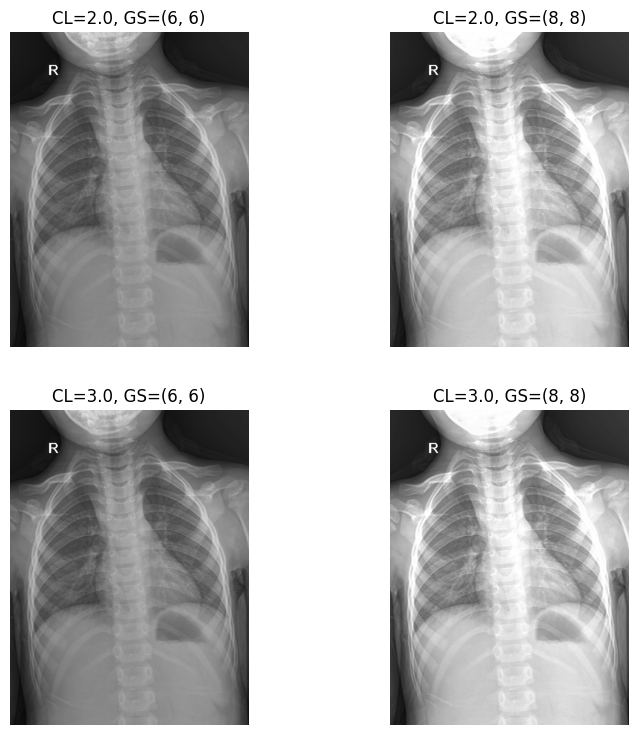

In [13]:
def plot_images(images, titles, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(9, 9))
    for i, (image, title) in enumerate(zip(images, titles)):
        ax = axes[i // cols, i % cols]
        ax.imshow(image, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    plt.show()


# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/000295d6ff55184f19d99e95f93c3a55.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/002cf1f4cba98648335843f21756ee36.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/0119beca31970c7d5293316a515d7ee9.dicom'
# path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/01b9c6193cfd9c247cad1b843a95aca7.dicom'
path = '/kaggle/input/vindr-pcxr-zipped/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/vindr-pcxr-an-open-large-scale-pediatric-chest-x-ray-dataset-for-interpretation-of-common-thoracic-diseases-1.0.0/train/021405230e5a837a061b9c87f9d2565b.dicom'

clipLimits = [2.0, 3.0]
tileGridSizes = [(6,6),(8,8)]
images = []
titles = []

for clipLimit in clipLimits:
    for tileSize in tileGridSizes:
        images.append(read_xray(path, clipLimit=clipLimit, tileGridSize=tileSize))
        titles.append(f"clipLimit={clipLimit}, tileGridSize={tileSize}")
    
titles = [f"CL={clipLimit}, GS={tileSize}" for clipLimit in clipLimits for tileSize in tileGridSizes]
plot_images(images, titles, len(clipLimits), len(tileGridSizes))

In [14]:
train_image_files = [
    os.path.join('/', train_paths[i]) for i in range(len(train_paths))
]
print(len(train_image_files))

val_image_files = [
    os.path.join('/', val_paths[i]) for i in range(len(val_paths))
]
print(len(val_image_files))

test_image_files = [
    os.path.join('/', test_paths[i]) for i in range(len(test_paths))
]
print(len(test_image_files)) 

6878
765
1386


image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)
image_shape: (512, 512)


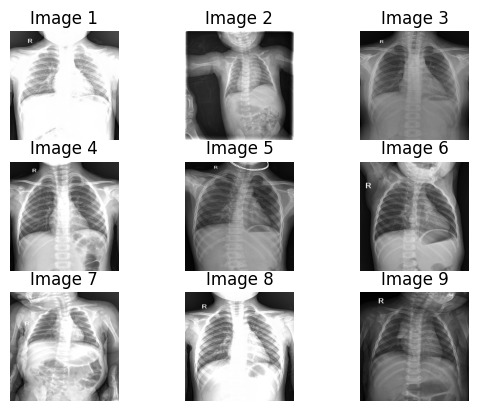

In [15]:
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Assuming train_image_files is a list of DICOM file paths
# Example:
# train_image_files = ["path/to/dicom/file1.dcm", "path/to/dicom/file2.dcm", ...]

for i, k in enumerate(np.random.randint(len(train_image_files), size=9)):
#     dicom_image = pydicom.dcmread(train_image_files[k])
    
    # Typecast to float64
#     float64_image_array = dicom_image.pixel_array.astype(np.float64)
    
    float64_image_array = np.load(train_image_files[k])
    print("image_shape:", float64_image_array.shape)
    
    # Visualization using Matplotlib
    plt.subplot(3, 3, i + 1)
    plt.imshow(float64_image_array, cmap='gray')  # Assuming grayscale DICOM images
    plt.title(f"Image {i + 1}")
    plt.axis('off')

plt.show()


In [16]:
BATCH_SIZE = 8
IMAGE_SIZE = (224,224) # the size to which the image would be resized before passing to the model
num_classes = len(diseases) 

print("BATCH_SIZE: ", BATCH_SIZE) 
print("IMAGE_SIZE: ", IMAGE_SIZE) 
print("num_classes:", num_classes)

BATCH_SIZE:  8
IMAGE_SIZE:  (224, 224)
num_classes: 6


In [17]:
from monai.transforms import Compose, Lambda, EnsureChannelFirst, ScaleIntensity,\
 RandRotate, RandFlip, RandZoom, RandSpatialCrop, RandRotate90, ResizeWithPadOrCrop, Resize

def load_tensor(data):
    # Convert the data to a supported data type (e.g., float32)
    return data.astype(np.float32)


train_transforms = Compose(
    [
#         LoadImage(image_only=True), 
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         RandSpatialCrop(IMAGE_SIZE[0],IMAGE_SIZE[1]), random_size=False),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE),
#         RandRotate90(prob=0.5, spatial_axes=(0, 1)),
        ScaleIntensity(),
#         RandRotate(range_x=np.pi / 12, prob=0.5, keep_size=True), # highly sensitive data
#         RandFlip(spatial_axis=0, prob=0.5),  # some abnormalities may be localized in a particular side
        RandZoom(min_zoom=0.9, max_zoom=1.1, prob=0.5),
    ]
)

val_transforms = Compose(
    [
#         LoadImage(image_only=True),
        Lambda(load_tensor),
        EnsureChannelFirst(channel_dim=0),
#         ResizeWithPadOrCrop(spatial_size=IMAGE_SIZE),
        Resize(spatial_size=(IMAGE_SIZE[0],IMAGE_SIZE[1])),

        ScaleIntensity(),

    ]
)

# y_pred_trans = Compose([Activations(softmax=True)])
# y_trans = Compose([AsDiscrete(to_onehot=num_class)])

y_pred_trans = Compose([Activations(sigmoid=True)]) # for multi-label classfication
y_trans = Compose([AsDiscrete(threshold_values=True)])


In [18]:
class VINDR_PCXR_Dataset(torch.utils.data.Dataset):
    def __init__(self, paths, labels, in_chans=1, transforms=None):
        self.paths = paths
        self.labels = labels
        self.transforms = transforms
        self.target_size = IMAGE_SIZE
        self.in_chans = in_chans
        
    def __len__(self):
        return len(self.paths)
    
    def __getitem__(self, index):
#         print(index)
        img_path = self.paths[index]
#         print(img_path, index)
        labels = self.labels[index]
#         labels = torch.tensor(labels.values, dtype=torch.long)  # Use dtype=torch.long
        
#         dicom = pydicom.read_file(img_path)
#         image = dicom.pixel_array.astype(np.float32)
#         image = read_xray(img_path, voi_lut = True, fix_monochrome = True, apply_clahe=True, clipLimit=2.0, tileGridSize=(6,6))
        
        image = np.load(img_path)
    
        # Expand the dimensions to add a channel dimension
        image = np.expand_dims(image, axis=0)
        
        if self.transforms:
            image = self.transforms(image)
        
        return image, labels


train_ds = VINDR_PCXR_Dataset(train_paths, train_labels, in_chans=1, transforms=train_transforms)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

val_ds = VINDR_PCXR_Dataset(val_paths, val_labels, in_chans=1, transforms=val_transforms)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, num_workers=4)

test_ds = VINDR_PCXR_Dataset(test_paths, test_labels, in_chans=1, transforms=val_transforms)
test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE, num_workers=4)

print("No. of TRAIN batches:", len(train_loader))
print("No. of VAL batches:", len(val_loader))
print("No. of TEST batches:", len(test_loader))


No. of TRAIN batches: 860
No. of VAL batches: 96
No. of TEST batches: 174


In [19]:
from thop import profile
from thop import clever_format
import torch

def display_params_flops(model):
    #params
    num_params = sum(p.numel() for p in model.parameters())
    num_params_millions = num_params / 1e6
    print(f"Number of parameters in millions: {num_params_millions:.2f} M")

    num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    num_params_millions = num_params / 1e6
    print(f"Number of trainable parameters in millions: {num_params_millions:.2f} M")


    #FLOPS
    input_size = (1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1])  


    # Move the model to GPU if available
    if torch.cuda.is_available():
        model = model.cuda()

    # Use thop.profile to count FLOPs
    input_tensor = torch.randn(*input_size)
    if torch.cuda.is_available():
        input_tensor = input_tensor.cuda()
    flops, params = profile(model, inputs=(input_tensor,))

    # Convert FLOPs to gigaFLOPs and format the results
    flops, params = clever_format([flops, params], "%.2f")
    print(f"FLOPs: {flops}, Params: {params}")
    

### Model Definition

In [20]:
import torch
import torch.nn as nn
import torchvision.models as models

from torch import nn
from timm import create_model


class CoatNetModel(nn.Module):
    def __init__(self, num_classes, fine_tune=False):
        super(CoatNetModel, self).__init__()
        self.coatnet = create_model(
            'timm/coatnet_3_rw_224.sw_in12k', # accepts only 224x224 images
            pretrained=True,
            num_classes=num_classes,
            in_chans=1
        )
        
        if not fine_tune:
            for param in self.coatnet.parameters():
                param.requires_grad = False
            
            for param in self.coatnet.head.parameters():
                param.requires_grad = True
        

    def forward(self, x):
        x = self.coatnet(x)
        return x
    
    
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CoatNetModel(num_classes, fine_tune=False)
model.to(device)

# print(model)
print()

x = torch.randn(1, 1, IMAGE_SIZE[0], IMAGE_SIZE[1]).to(device)


output = model(x)
print("Model output's shape:", output.shape)
print(output) # logits
display_params_flops(model)

model.safetensors:   0%|          | 0.00/727M [00:00<?, ?B/s]


Model output's shape: torch.Size([1, 6])
tensor([[-0.7358,  1.7112, -0.7665, -0.0276,  1.5399, -2.4704]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
Number of parameters in millions: 163.64 M
Number of trainable parameters in millions: 0.01 M
[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[INFO] Register count_avgpool() for <class 'torch.nn.modules.pooling.AvgPool2d'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.container.Sequential'>.
[INFO] Register zero_ops() for <class 'torch.nn.modules.dropout.Dropout'>.
[INFO] Register count_adap_avgpool() for <class 'torch.nn.modules.pooling.AdaptiveAvgPool2d'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
FLOPs: 32.49G, Params: 163.27M


In [21]:
model = CoatNetModel(num_classes, fine_tune=False) # change fine_tune as required
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 3e-5) # adjust learning rate 
# reduce lr during fine tuning

In [22]:
import torch
import torch.nn as nn

# Assuming your model outputs logits
logits = torch.randn(3, num_classes)  # Example logits
targets = torch.randint(0, 2, (3, num_classes))  # Example targets (binary, one-hot encoded)
print(logits)
print(targets)

# Define the loss function
criterion = nn.BCEWithLogitsLoss()

# Calculate the loss
loss = criterion(logits, targets.float())
print("loss:", loss)

tensor([[-0.1444, -1.0233, -1.8232, -0.5646, -0.1522,  0.4321],
        [ 0.9575,  0.5613, -1.2500,  0.8654,  0.1977,  0.3553],
        [ 0.1003, -0.6419,  0.1480,  0.7880, -0.1271,  0.5558]])
tensor([[0, 0, 0, 1, 1, 1],
        [0, 1, 0, 0, 0, 1],
        [1, 0, 1, 0, 1, 0]])
loss: tensor(0.6954)


In [23]:
def train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=20,
          ranOnce=False, epochs_ran=0, model_path='model.pth', history_path='history.csv',
         save_interval=1):
    '''
    returns the 'history' dataframe.
    
    This function trains the model for a fixed number of epochs,
    saving the checkpoints regularly.
    It monitors time taken per epoch and total time elapsed.
    It tracks loss, roc_auc, f1, accuracy, precision, recall for both train & validation data.
    It also saves the best model on loss, roc_auc, f1 and accuracy.
    '''
    
    
    initial_epoch = 0
    
    valid_loss_min = np.Inf
    valid_max_accuracy = 0
    valid_max_auc = 0
    valid_max_precision = 0
    valid_max_recall = 0
    valid_max_f1 = 0
    
    
    
    if ranOnce:
        if epochs_ran <= 0:
            print("Mention the no. of epochs run by the model already for which you have the weights")
            return 

        history = pd.read_csv(history_path)
        history=history.head(epochs_ran)
        model.load_state_dict(torch.load(model_path))
        '''
        It has the following columns:-
        epoch_number, train_loss, val_loss, train_auc, val_auc, train_accuracy, val_accuracy,
        train_f1, val_f1, train_precision, val_precision, train_recall, val_recall,
        time_current_epoch, total_time_elapsed
        '''
        initial_epoch = len(history)
        
        valid_loss_min = history['val_loss'].min()
        valid_max_accuracy = history['val_accuracy'].max()
        valid_max_auc = history['val_auc'].max()
        valid_max_precision = history['val_precision'].max()
        valid_max_recall = history['val_recall'].max()
        valid_max_f1 = history['val_f1'].max()
        
        
        print(f"Model was already trained fo {initial_epoch} epochs,\
    with minimum loss: {valid_loss_min}, max accuracy: {valid_max_accuracy},\
    max auc: {valid_max_auc}, max precision: {valid_max_precision}, \
    max recall: {valid_max_recall}, max f1: {valid_max_f1}")
        
    else:
        print("Starting afresh!")
        history = pd.DataFrame()
#         history = pd.DataFrame(columns=['epoch_number', 'train_loss', 'train_accuracy', 'train_f1',\
#             'train_precision', 'train_recall', 'train_auc', 'train_auc_scores',\
#             'val_loss', 'val_accuracy', 'val_f1', 'val_precision', 'val_recall', 'val_auc','val_auc_scores',\
#             'time_current_epoch'])
        
    # Main loop
    for epoch in range(initial_epoch+1, initial_epoch + num_epochs+1):
        
        history_list = [] # stores the history for the current epoch in a list 
        
        train_labels_all = []
        train_predictions_all = []
        train_scores_all = []
        
        train_loss = 0.0
        correct_train = 0
        total_train = 0
        
         # Set to training
        model.train()
        start = timer()
        
        # Training loop
        for batch_data in tqdm(train_loader):
            inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  
            
            # Clear gradients
            optimizer.zero_grad()

            outputs = model(inputs)
#             print("train_batch_outputs:", outputs)
#             print("train_batch_labels:", labels)
            
            outputs = outputs.float()
            labels = labels.float()

            # Loss and backpropagation of gradients
            loss = loss_function(outputs, labels)

            loss.backward()
            optimizer.step()  # Update the parameters
            
            train_loss += loss.item()
            
            # Calculate training accuracy
            scores = torch.sigmoid(outputs)
            predictions = torch.sigmoid(outputs) > 0.5
            total_train += labels.size(0) * labels.size(1)
            
            correct_train += (predictions == labels).sum().item()
            
#             print("train_batch_predictions:", predictions)
#             print("train_batch_scores:", scores)
            
            train_scores_all.extend(scores.detach().cpu().numpy())
            train_labels_all.extend(labels.cpu().numpy())
            train_predictions_all.extend(predictions.cpu().numpy())
            
#             train_labels_all.extend(labels)
#             train_predictions_all.extend(predictions)
            
    
        train_loss /= len(train_loader)
        accuracy_train = correct_train / total_train
        
        print(f"Current epoch {epoch}/{initial_epoch + num_epochs}")
        print(f"Training Loss: {train_loss:.4f}, Accuracy: {accuracy_train:.4f}")
        print("correct:", correct_train, " out of ", total_train)

        train_predictions_all = np.array(train_predictions_all).astype(float)
        train_labels_all = np.array(train_labels_all).astype(float)
        
#         print(classification_report(train_labels_all, train_predictions_all, target_names=diseases))
        
        cm = multilabel_confusion_matrix(train_predictions_all, train_labels_all)
        # we will use macro-averaging strategy.
        accuracy_arr = []
        precision_arr = []
        recall_arr = []
        f1_arr = []
        
        for i in range(num_classes):
#             print(cm[i])
#             print(cm[i].sum())
            
#             cfm_plot = sn.heatmap(cm[i], annot=False)
             # TP + TN / TP + TN  + FP + FN
            accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

            # TP / TP + FP
            precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

            # TP / TP + FN
            recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
            f1 = (2*precision*recall)/(precision+recall)
#             print(diseases[i],": ",round(accuracy*100,2),"%")
#             print("Precision: ",round(precision,2))
#             print("Recall:", round(recall,2))
#             print("F1-Score:", round(f1,2))
#             print('==========================================================')


            accuracy_arr.append(accuracy)
            precision_arr.append(precision)
            recall_arr.append(recall)
            f1_arr.append(f1)
        
        
        accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
        precision_arr = np.nan_to_num(precision_arr, nan=0)
        recall_arr = np.nan_to_num(recall_arr, nan=0)
        f1_arr = np.nan_to_num(f1_arr, nan=0)
        
        accuracy_macro_train = round(sum(accuracy_arr) / len(accuracy_arr), 4)
        precision_macro_train = round(sum(precision_arr) / len(precision_arr), 4)
        recall_macro_train = round(sum(recall_arr) / len(recall_arr), 4)
        f1_macro_train = round(sum(f1_arr) / len(f1_arr), 4)
        roc_auc_macro_train = round(roc_auc_score(train_labels_all, train_scores_all, average='macro'), 4)

        print("MACRO-averged metrics", end=':- ')
        print(f"accuracy: {accuracy_macro_train}, precision: {precision_macro_train}", end=', ')
        print(f"recall: {recall_macro_train}, f1: {f1_macro_train}, ROC_AUC: {roc_auc_macro_train}")

        
        #VALIDATION START:->
        val_labels_all = []
        val_predictions_all = []
        val_scores_all = []
        
        val_loss = 0.0
        correct_val = 0
        total_val = 0
        
        # Don't need to keep track of gradients
        with torch.no_grad():
            # Set to evaluation mode
            model.eval()
        
            #Validation loop
            for batch_data in tqdm(val_loader):
                inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

                outputs = model(inputs)
                outputs = outputs.float()
                labels = labels.float()
                
                loss = loss_function(outputs, labels)                
                val_loss += loss.item()

                scores = torch.sigmoid(outputs)
                predictions = torch.sigmoid(outputs) > 0.5
                total_val += labels.size(0) * labels.size(1)
                
                correct_val += (predictions == labels).sum().item()
                
                val_scores_all.extend(scores.detach().cpu().numpy())
                val_labels_all.extend(labels.cpu().numpy())
                val_predictions_all.extend(predictions.cpu().numpy())
                

            val_loss /= len(val_loader)
            accuracy_val = correct_val / total_val

            print(f"Validation Loss: {val_loss:.4f}, Accuracy: {accuracy_val:.4f}")
            print("correct:", correct_val, " out of ", total_val)

            val_predictions_all = np.array(val_predictions_all).astype(float)
            val_labels_all = np.array(val_labels_all).astype(float)

    #         print(classification_report(val_labels_all, val_predictions_all, target_names=diseases))

            cm = multilabel_confusion_matrix(val_predictions_all, val_labels_all)
            # we will use macro-averaging strategy.
            accuracy_arr = []
            precision_arr = []
            recall_arr = []
            f1_arr = []

            for i in range(num_classes):
    #             print(cm[i])
    #             print(cm[i].sum())

    #             cfm_plot = sn.heatmap(cm[i], annot=False)
#                 TP + TN / TP + TN  + FP + FN
                accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

                # TP / TP + FP
                precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

                # TP / TP + FN
                recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
                f1 = (2*precision*recall)/(precision+recall)
    #             print(diseases[i],": ",round(accuracy*100,2),"%")
    #             print("Precision: ",round(precision,2))
    #             print("Recall:", round(recall,2))
    #             print("F1-Score:", round(f1,2))
    #             print('==========================================================')

        
                accuracy_arr.append(accuracy)
                precision_arr.append(precision)
                recall_arr.append(recall)
                f1_arr.append(f1)
            
            accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
            precision_arr = np.nan_to_num(precision_arr, nan=0)
            recall_arr = np.nan_to_num(recall_arr, nan=0)
            f1_arr = np.nan_to_num(f1_arr, nan=0)
            
            accuracy_macro_val = round(sum(accuracy_arr) / len(accuracy_arr), 4)
            precision_macro_val = round(sum(precision_arr) / len(precision_arr), 4)
            recall_macro_val = round(sum(recall_arr) / len(recall_arr), 4)
            f1_macro_val = round(sum(f1_arr) / len(f1_arr), 4)
            roc_auc_macro_val = round(roc_auc_score(val_labels_all, val_scores_all, average='macro'), 4)
            
            print("MACRO-averged metrics", end=':- ')
            print(f"accuracy: {accuracy_macro_val}, precision: {precision_macro_val}", end=', ')
            print(f"recall: {recall_macro_val}, f1: {f1_macro_val}, ROC_AUC: {roc_auc_macro_val}")

            time_this_epoch = timer()-start
            print(f"Time_for_this_epoch: {(time_this_epoch):.4f} seconds")
            print("-"*120)

        
#         Add values to the history DataFrame
        history_list.append({
            'epoch_number': epoch,
            'train_loss': train_loss,
            'train_accuracy': accuracy_macro_train,
            'train_f1': f1_macro_train,
            'train_precision': precision_macro_train,
            'train_recall': recall_macro_train,
            'train_auc': roc_auc_macro_train,
            
            'val_loss': val_loss,
            'val_accuracy': accuracy_macro_val,
            'val_f1': f1_macro_val,
            'val_precision': precision_macro_val,
            'val_recall': recall_macro_val,
            'val_auc': roc_auc_macro_val,
            
            # Add other metrics as needed
            'time_current_epoch': time_this_epoch
        })
        
        # Convert the list of dictionaries to a DataFrame
        epoch_history = pd.DataFrame(history_list)

        # Concatenate the new DataFrame with the existing history DataFrame
        history = pd.concat([history, epoch_history], ignore_index=True)
        
        history.to_csv('history.csv', index=False)
#         print("history_list:", history_list)
        print('history should be saved')
        
        
#         ### HANDLING THE MODEL SAVING MECHANISM
# #       # Save the model with the best accuracy
        if accuracy_macro_val > valid_max_accuracy:
            valid_max_accuracy = accuracy_macro_val
            best_model_accuracy = model.state_dict()
            torch.save(best_model_accuracy, 'best_model_accuracy.pth')


#         # Save the model with the best AUC
        if roc_auc_macro_val > valid_max_auc:
            valid_max_auc = roc_auc_macro_val
            best_model_auc = model.state_dict()
            torch.save(best_model_auc, 'best_model_auc.pth')


#         # Save the model with the best validation loss
        if val_loss < valid_loss_min:
            valid_loss_min = val_loss
            best_model_val_loss = model.state_dict()
            torch.save(best_model_val_loss, 'best_model_val_loss.pth')
            
        # best precision
        if precision_macro_val > valid_max_precision:
            valid_max_precision = precision_macro_val
            best_model_precision = model.state_dict()
            torch.save(best_model_precision, 'best_model_precision.pth')
        
        # best recall 
        if recall_macro_val > valid_max_recall :
            valid_max_recall  = recall_macro_val
            best_model_recall = model.state_dict()
            torch.save(best_model_recall, 'best_model_recall.pth')
        
        # best f1
        if f1_macro_val > valid_max_f1 :
            valid_max_f1  = f1_macro_val
            best_model_f1 = model.state_dict()
            torch.save(best_model_f1, 'best_model_f1.pth')
            

#         # Saving model every 'save_interval' number of epochs
        if epoch % save_interval == 0:
            print(f"Saving model at epoch number: {epoch}")
            torch.save(model.state_dict(), f"model_{epoch}.pth")
        

        
    return history

In [24]:
 history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=30,
          ranOnce=False,
         save_interval=10)

Starting afresh!


100%|██████████| 860/860 [01:59<00:00,  7.22it/s]


Current epoch 1/30
Training Loss: 0.3426, Accuracy: 0.8710
correct: 35946  out of  41268
MACRO-averged metrics:- accuracy: 0.871, precision: 0.1737, recall: 0.1626, f1: 0.1477, ROC_AUC: 0.5395


100%|██████████| 96/96 [00:13<00:00,  7.17it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3237, Accuracy: 0.8830
correct: 4053  out of  4590
MACRO-averged metrics:- accuracy: 0.883, precision: 0.1155, recall: 0.1502, f1: 0.1306, ROC_AUC: 0.549
Time_for_this_epoch: 132.6516 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 2/30
Training Loss: 0.3147, Accuracy: 0.8847
correct: 36510  out of  41268
MACRO-averged metrics:- accuracy: 0.8847, precision: 0.2286, recall: 0.1579, f1: 0.1379, ROC_AUC: 0.5916


100%|██████████| 96/96 [00:13<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3180, Accuracy: 0.8871
correct: 4072  out of  4590
MACRO-averged metrics:- accuracy: 0.8871, precision: 0.1153, recall: 0.1586, f1: 0.1335, ROC_AUC: 0.5663
Time_for_this_epoch: 132.0273 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 3/30
Training Loss: 0.3085, Accuracy: 0.8870
correct: 36605  out of  41268
MACRO-averged metrics:- accuracy: 0.887, precision: 0.2723, recall: 0.1604, f1: 0.1402, ROC_AUC: 0.6144


100%|██████████| 96/96 [00:13<00:00,  7.25it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3146, Accuracy: 0.8858
correct: 4066  out of  4590
MACRO-averged metrics:- accuracy: 0.8858, precision: 0.2823, recall: 0.1594, f1: 0.1406, ROC_AUC: 0.5927
Time_for_this_epoch: 132.1118 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 4/30
Training Loss: 0.3049, Accuracy: 0.8884
correct: 36661  out of  41268
MACRO-averged metrics:- accuracy: 0.8884, precision: 0.3488, recall: 0.1618, f1: 0.1435, ROC_AUC: 0.6342


100%|██████████| 96/96 [00:13<00:00,  7.27it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3148, Accuracy: 0.8830
correct: 4053  out of  4590
MACRO-averged metrics:- accuracy: 0.883, precision: 0.1587, recall: 0.1439, f1: 0.1322, ROC_AUC: 0.6035
Time_for_this_epoch: 132.0117 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 5/30
Training Loss: 0.3027, Accuracy: 0.8895
correct: 36708  out of  41268
MACRO-averged metrics:- accuracy: 0.8895, precision: 0.3655, recall: 0.1625, f1: 0.1442, ROC_AUC: 0.6442


100%|██████████| 96/96 [00:13<00:00,  7.29it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3127, Accuracy: 0.8841
correct: 4058  out of  4590
MACRO-averged metrics:- accuracy: 0.8841, precision: 0.201, recall: 0.1462, f1: 0.1365, ROC_AUC: 0.606
Time_for_this_epoch: 131.6495 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.27it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 6/30
Training Loss: 0.3005, Accuracy: 0.8893
correct: 36699  out of  41268
MACRO-averged metrics:- accuracy: 0.8893, precision: 0.361, recall: 0.1631, f1: 0.1465, ROC_AUC: 0.6532


100%|██████████| 96/96 [00:13<00:00,  7.30it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3116, Accuracy: 0.8878
correct: 4075  out of  4590
MACRO-averged metrics:- accuracy: 0.8878, precision: 0.1995, recall: 0.161, f1: 0.1413, ROC_AUC: 0.6129
Time_for_this_epoch: 131.5243 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.28it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 7/30
Training Loss: 0.2980, Accuracy: 0.8902
correct: 36738  out of  41268
MACRO-averged metrics:- accuracy: 0.8902, precision: 0.3401, recall: 0.1644, f1: 0.1485, ROC_AUC: 0.6646


100%|██████████| 96/96 [00:13<00:00,  7.31it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3101, Accuracy: 0.8843
correct: 4059  out of  4590
MACRO-averged metrics:- accuracy: 0.8843, precision: 0.2003, recall: 0.1501, f1: 0.1376, ROC_AUC: 0.6184
Time_for_this_epoch: 131.3380 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.27it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 8/30
Training Loss: 0.2967, Accuracy: 0.8904
correct: 36743  out of  41268
MACRO-averged metrics:- accuracy: 0.8904, precision: 0.4052, recall: 0.1634, f1: 0.1466, ROC_AUC: 0.671


100%|██████████| 96/96 [00:13<00:00,  7.28it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3100, Accuracy: 0.8871
correct: 4072  out of  4590
MACRO-averged metrics:- accuracy: 0.8871, precision: 0.1581, recall: 0.1578, f1: 0.1372, ROC_AUC: 0.6238
Time_for_this_epoch: 131.4801 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 9/30
Training Loss: 0.2960, Accuracy: 0.8902
correct: 36738  out of  41268
MACRO-averged metrics:- accuracy: 0.8902, precision: 0.4132, recall: 0.1637, f1: 0.1495, ROC_AUC: 0.6725


100%|██████████| 96/96 [00:13<00:00,  7.28it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3105, Accuracy: 0.8874
correct: 4073  out of  4590
MACRO-averged metrics:- accuracy: 0.8874, precision: 0.2563, recall: 0.16, f1: 0.1479, ROC_AUC: 0.6217
Time_for_this_epoch: 131.7672 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 10/30
Training Loss: 0.2937, Accuracy: 0.8909
correct: 36764  out of  41268
MACRO-averged metrics:- accuracy: 0.8909, precision: 0.455, recall: 0.1648, f1: 0.1516, ROC_AUC: 0.6855


100%|██████████| 96/96 [00:13<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3094, Accuracy: 0.8858
correct: 4066  out of  4590
MACRO-averged metrics:- accuracy: 0.8858, precision: 0.2012, recall: 0.1514, f1: 0.1387, ROC_AUC: 0.6294
Time_for_this_epoch: 132.1133 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 10


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 11/30
Training Loss: 0.2929, Accuracy: 0.8907
correct: 36758  out of  41268
MACRO-averged metrics:- accuracy: 0.8907, precision: 0.3926, recall: 0.1631, f1: 0.1499, ROC_AUC: 0.69


100%|██████████| 96/96 [00:13<00:00,  7.25it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3115, Accuracy: 0.8865
correct: 4069  out of  4590
MACRO-averged metrics:- accuracy: 0.8865, precision: 0.2009, recall: 0.1539, f1: 0.1395, ROC_AUC: 0.6307
Time_for_this_epoch: 132.1626 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.25it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 12/30
Training Loss: 0.2915, Accuracy: 0.8920
correct: 36812  out of  41268
MACRO-averged metrics:- accuracy: 0.892, precision: 0.4907, recall: 0.1652, f1: 0.1526, ROC_AUC: 0.6927


100%|██████████| 96/96 [00:13<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3089, Accuracy: 0.8869
correct: 4071  out of  4590
MACRO-averged metrics:- accuracy: 0.8869, precision: 0.1725, recall: 0.1568, f1: 0.1401, ROC_AUC: 0.6306
Time_for_this_epoch: 131.9382 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.25it/s]


Current epoch 13/30
Training Loss: 0.2921, Accuracy: 0.8910
correct: 36770  out of  41268
MACRO-averged metrics:- accuracy: 0.891, precision: 0.5855, recall: 0.1676, f1: 0.1588, ROC_AUC: 0.6926


100%|██████████| 96/96 [00:13<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3097, Accuracy: 0.8880
correct: 4076  out of  4590
MACRO-averged metrics:- accuracy: 0.888, precision: 0.2839, recall: 0.1594, f1: 0.1415, ROC_AUC: 0.6319
Time_for_this_epoch: 131.8616 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.26it/s]


Current epoch 14/30
Training Loss: 0.2905, Accuracy: 0.8927
correct: 36839  out of  41268
MACRO-averged metrics:- accuracy: 0.8927, precision: 0.6021, recall: 0.1691, f1: 0.1606, ROC_AUC: 0.698


100%|██████████| 96/96 [00:13<00:00,  7.28it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3096, Accuracy: 0.8878
correct: 4075  out of  4590
MACRO-averged metrics:- accuracy: 0.8878, precision: 0.1726, recall: 0.1594, f1: 0.1411, ROC_AUC: 0.6304
Time_for_this_epoch: 131.7461 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.25it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 15/30
Training Loss: 0.2894, Accuracy: 0.8923
correct: 36822  out of  41268
MACRO-averged metrics:- accuracy: 0.8923, precision: 0.4089, recall: 0.1665, f1: 0.156, ROC_AUC: 0.7024


100%|██████████| 96/96 [00:13<00:00,  7.25it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3090, Accuracy: 0.8852
correct: 4063  out of  4590
MACRO-averged metrics:- accuracy: 0.8852, precision: 0.245, recall: 0.1553, f1: 0.1492, ROC_AUC: 0.6345
Time_for_this_epoch: 132.0020 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 16/30
Training Loss: 0.2885, Accuracy: 0.8920
correct: 36809  out of  41268
MACRO-averged metrics:- accuracy: 0.892, precision: 0.5112, recall: 0.166, f1: 0.1572, ROC_AUC: 0.7086


100%|██████████| 96/96 [00:13<00:00,  7.27it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3086, Accuracy: 0.8837
correct: 4056  out of  4590
MACRO-averged metrics:- accuracy: 0.8837, precision: 0.2053, recall: 0.1541, f1: 0.1418, ROC_AUC: 0.6344
Time_for_this_epoch: 132.0773 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.25it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 17/30
Training Loss: 0.2879, Accuracy: 0.8921
correct: 36815  out of  41268
MACRO-averged metrics:- accuracy: 0.8921, precision: 0.498, recall: 0.1677, f1: 0.159, ROC_AUC: 0.7098


100%|██████████| 96/96 [00:13<00:00,  7.27it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3094, Accuracy: 0.8854
correct: 4064  out of  4590
MACRO-averged metrics:- accuracy: 0.8854, precision: 0.2413, recall: 0.1513, f1: 0.1454, ROC_AUC: 0.636
Time_for_this_epoch: 131.9407 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.25it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 18/30
Training Loss: 0.2870, Accuracy: 0.8927
correct: 36840  out of  41268
MACRO-averged metrics:- accuracy: 0.8927, precision: 0.5541, recall: 0.1686, f1: 0.1611, ROC_AUC: 0.7124


100%|██████████| 96/96 [00:13<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3076, Accuracy: 0.8865
correct: 4069  out of  4590
MACRO-averged metrics:- accuracy: 0.8865, precision: 0.2998, recall: 0.1677, f1: 0.1615, ROC_AUC: 0.639
Time_for_this_epoch: 131.9213 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.23it/s]


Current epoch 19/30
Training Loss: 0.2860, Accuracy: 0.8929
correct: 36849  out of  41268
MACRO-averged metrics:- accuracy: 0.8929, precision: 0.628, recall: 0.1687, f1: 0.1611, ROC_AUC: 0.7156


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3084, Accuracy: 0.8876
correct: 4074  out of  4590
MACRO-averged metrics:- accuracy: 0.8876, precision: 0.2006, recall: 0.1581, f1: 0.1409, ROC_AUC: 0.6373
Time_for_this_epoch: 132.2518 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]


Current epoch 20/30
Training Loss: 0.2853, Accuracy: 0.8933
correct: 36863  out of  41268
MACRO-averged metrics:- accuracy: 0.8933, precision: 0.6597, recall: 0.1716, f1: 0.1667, ROC_AUC: 0.7196


100%|██████████| 96/96 [00:13<00:00,  7.28it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3090, Accuracy: 0.8874
correct: 4073  out of  4590
MACRO-averged metrics:- accuracy: 0.8874, precision: 0.2843, recall: 0.1587, f1: 0.1478, ROC_AUC: 0.6391
Time_for_this_epoch: 132.0524 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 20


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 21/30
Training Loss: 0.2852, Accuracy: 0.8933
correct: 36866  out of  41268
MACRO-averged metrics:- accuracy: 0.8933, precision: 0.5841, recall: 0.1696, f1: 0.1636, ROC_AUC: 0.719


100%|██████████| 96/96 [00:13<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3078, Accuracy: 0.8869
correct: 4071  out of  4590
MACRO-averged metrics:- accuracy: 0.8869, precision: 0.1729, recall: 0.1562, f1: 0.1401, ROC_AUC: 0.6394
Time_for_this_epoch: 132.1438 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]


Current epoch 22/30
Training Loss: 0.2846, Accuracy: 0.8938
correct: 36885  out of  41268
MACRO-averged metrics:- accuracy: 0.8938, precision: 0.6922, recall: 0.1735, f1: 0.171, ROC_AUC: 0.7212


100%|██████████| 96/96 [00:13<00:00,  7.25it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3069, Accuracy: 0.8845
correct: 4060  out of  4590
MACRO-averged metrics:- accuracy: 0.8845, precision: 0.2845, recall: 0.1536, f1: 0.1483, ROC_AUC: 0.6458
Time_for_this_epoch: 132.1249 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 23/30
Training Loss: 0.2836, Accuracy: 0.8941
correct: 36897  out of  41268
MACRO-averged metrics:- accuracy: 0.8941, precision: 0.5889, recall: 0.1727, f1: 0.1689, ROC_AUC: 0.7263


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3108, Accuracy: 0.8837
correct: 4056  out of  4590
MACRO-averged metrics:- accuracy: 0.8837, precision: 0.264, recall: 0.1518, f1: 0.1479, ROC_AUC: 0.6408
Time_for_this_epoch: 132.2408 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 24/30
Training Loss: 0.2826, Accuracy: 0.8943
correct: 36904  out of  41268
MACRO-averged metrics:- accuracy: 0.8943, precision: 0.5614, recall: 0.1733, f1: 0.1706, ROC_AUC: 0.7302


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3090, Accuracy: 0.8837
correct: 4056  out of  4590
MACRO-averged metrics:- accuracy: 0.8837, precision: 0.2519, recall: 0.1525, f1: 0.1508, ROC_AUC: 0.6432
Time_for_this_epoch: 132.2817 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 25/30
Training Loss: 0.2827, Accuracy: 0.8944
correct: 36911  out of  41268
MACRO-averged metrics:- accuracy: 0.8944, precision: 0.5926, recall: 0.175, f1: 0.1742, ROC_AUC: 0.7285


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3102, Accuracy: 0.8854
correct: 4064  out of  4590
MACRO-averged metrics:- accuracy: 0.8854, precision: 0.2019, recall: 0.1497, f1: 0.1385, ROC_AUC: 0.6385
Time_for_this_epoch: 132.2835 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.23it/s]


Current epoch 26/30
Training Loss: 0.2819, Accuracy: 0.8945
correct: 36916  out of  41268
MACRO-averged metrics:- accuracy: 0.8945, precision: 0.6415, recall: 0.1745, f1: 0.1746, ROC_AUC: 0.7302


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3081, Accuracy: 0.8880
correct: 4076  out of  4590
MACRO-averged metrics:- accuracy: 0.888, precision: 0.2429, recall: 0.1628, f1: 0.152, ROC_AUC: 0.6497
Time_for_this_epoch: 132.2978 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 27/30
Training Loss: 0.2813, Accuracy: 0.8948
correct: 36925  out of  41268
MACRO-averged metrics:- accuracy: 0.8948, precision: 0.591, recall: 0.1752, f1: 0.1743, ROC_AUC: 0.7319


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3089, Accuracy: 0.8839
correct: 4057  out of  4590
MACRO-averged metrics:- accuracy: 0.8839, precision: 0.2293, recall: 0.1507, f1: 0.1445, ROC_AUC: 0.6472
Time_for_this_epoch: 132.2728 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:59<00:00,  7.22it/s]


Current epoch 28/30
Training Loss: 0.2810, Accuracy: 0.8940
correct: 36895  out of  41268
MACRO-averged metrics:- accuracy: 0.894, precision: 0.6891, recall: 0.1743, f1: 0.1743, ROC_AUC: 0.735


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3095, Accuracy: 0.8858
correct: 4066  out of  4590
MACRO-averged metrics:- accuracy: 0.8858, precision: 0.3683, recall: 0.1577, f1: 0.1535, ROC_AUC: 0.6467
Time_for_this_epoch: 132.3625 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 29/30
Training Loss: 0.2802, Accuracy: 0.8949
correct: 36929  out of  41268
MACRO-averged metrics:- accuracy: 0.8949, precision: 0.5828, recall: 0.1768, f1: 0.1779, ROC_AUC: 0.7357


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3084, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.3678, recall: 0.1551, f1: 0.1434, ROC_AUC: 0.6474
Time_for_this_epoch: 132.0748 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [01:58<00:00,  7.23it/s]


Current epoch 30/30
Training Loss: 0.2798, Accuracy: 0.8949
correct: 36929  out of  41268
MACRO-averged metrics:- accuracy: 0.8949, precision: 0.7159, recall: 0.1732, f1: 0.1721, ROC_AUC: 0.7376


100%|██████████| 96/96 [00:13<00:00,  7.26it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3083, Accuracy: 0.8852
correct: 4063  out of  4590
MACRO-averged metrics:- accuracy: 0.8852, precision: 0.2507, recall: 0.1608, f1: 0.1622, ROC_AUC: 0.6486
Time_for_this_epoch: 132.1987 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 30


### Fine Tune ( replace model name )

In [25]:
model = CoatNetModel(num_classes, fine_tune=True) # change fine_tune as required
model.to(device)


loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), 7e-6) # adjust learning rate 
# reduce lr during fine tuning

In [26]:
# give the correct model & history paths & "epochs_ran" must be matching with model_{no.}

history = train(model, loss_function=loss_function, optimizer=optimizer, num_epochs=70,
          ranOnce=True, model_path='/kaggle/working/model_30.pth', history_path='/kaggle/working/history.csv',
         epochs_ran=30, save_interval=10)

Model was already trained fo 30 epochs,    with minimum loss: 0.3069204475420217, max accuracy: 0.888,    max auc: 0.6497, max precision: 0.3683,     max recall: 0.1677, max f1: 0.1622


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])
/tmp/ipykernel_26/3941032153.py:152: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Current epoch 31/100
Training Loss: 0.3012, Accuracy: 0.8906
correct: 36752  out of  41268
MACRO-averged metrics:- accuracy: 0.8906, precision: 0.2271, recall: 0.1517, f1: 0.1399, ROC_AUC: 0.6582


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3137, Accuracy: 0.8834
correct: 4055  out of  4590
MACRO-averged metrics:- accuracy: 0.8834, precision: 0.1929, recall: 0.128, f1: 0.1453, ROC_AUC: 0.7054
Time_for_this_epoch: 461.7472 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]
/tmp/ipykernel_26/3941032153.py:148: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Current epoch 32/100
Training Loss: 0.2750, Accuracy: 0.8991
correct: 37106  out of  41268
MACRO-averged metrics:- accuracy: 0.8991, precision: 0.5483, recall: 0.1691, f1: 0.176, ROC_AUC: 0.7437


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.3102, Accuracy: 0.8935
correct: 4101  out of  4590
MACRO-averged metrics:- accuracy: 0.8935, precision: 0.1753, recall: 0.1661, f1: 0.1482, ROC_AUC: 0.7097
Time_for_this_epoch: 461.3429 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 33/100
Training Loss: 0.2473, Accuracy: 0.9078
correct: 37465  out of  41268
MACRO-averged metrics:- accuracy: 0.9078, precision: 0.6297, recall: 0.2054, f1: 0.2393, ROC_AUC: 0.8159


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.2962, Accuracy: 0.8887
correct: 4079  out of  4590
MACRO-averged metrics:- accuracy: 0.8887, precision: 0.3315, recall: 0.1522, f1: 0.1681, ROC_AUC: 0.7218
Time_for_this_epoch: 460.7554 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 34/100
Training Loss: 0.1923, Accuracy: 0.9249
correct: 38167  out of  41268
MACRO-averged metrics:- accuracy: 0.9249, precision: 0.6789, recall: 0.3293, f1: 0.4087, ROC_AUC: 0.9007


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.3077, Accuracy: 0.8978
correct: 4121  out of  4590
MACRO-averged metrics:- accuracy: 0.8978, precision: 0.4176, recall: 0.1804, f1: 0.1947, ROC_AUC: 0.7429
Time_for_this_epoch: 461.0608 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 35/100
Training Loss: 0.1145, Accuracy: 0.9541
correct: 39375  out of  41268
MACRO-averged metrics:- accuracy: 0.9541, precision: 0.7847, recall: 0.5903, f1: 0.6667, ROC_AUC: 0.9665


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]


Validation Loss: 0.3956, Accuracy: 0.8852
correct: 4063  out of  4590
MACRO-averged metrics:- accuracy: 0.8852, precision: 0.3637, recall: 0.2031, f1: 0.2448, ROC_AUC: 0.7251
Time_for_this_epoch: 460.6478 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 36/100
Training Loss: 0.0616, Accuracy: 0.9765
correct: 40299  out of  41268
MACRO-averged metrics:- accuracy: 0.9765, precision: 0.8833, recall: 0.8164, f1: 0.8479, ROC_AUC: 0.9904


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]


Validation Loss: 0.5800, Accuracy: 0.8660
correct: 3975  out of  4590
MACRO-averged metrics:- accuracy: 0.866, precision: 0.3071, recall: 0.2257, f1: 0.2238, ROC_AUC: 0.6983
Time_for_this_epoch: 461.0541 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 37/100
Training Loss: 0.0379, Accuracy: 0.9862
correct: 40699  out of  41268
MACRO-averged metrics:- accuracy: 0.9862, precision: 0.9337, recall: 0.9045, f1: 0.9187, ROC_AUC: 0.9965


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]


Validation Loss: 0.6519, Accuracy: 0.8702
correct: 3994  out of  4590
MACRO-averged metrics:- accuracy: 0.8702, precision: 0.2938, recall: 0.2337, f1: 0.2543, ROC_AUC: 0.7094
Time_for_this_epoch: 461.0088 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 38/100
Training Loss: 0.0240, Accuracy: 0.9917
correct: 40925  out of  41268
MACRO-averged metrics:- accuracy: 0.9917, precision: 0.9603, recall: 0.9481, f1: 0.9542, ROC_AUC: 0.9984


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]


Validation Loss: 0.6574, Accuracy: 0.8852
correct: 4063  out of  4590
MACRO-averged metrics:- accuracy: 0.8852, precision: 0.282, recall: 0.2074, f1: 0.2136, ROC_AUC: 0.7095
Time_for_this_epoch: 460.7188 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 39/100
Training Loss: 0.0218, Accuracy: 0.9922
correct: 40948  out of  41268
MACRO-averged metrics:- accuracy: 0.9922, precision: 0.961, recall: 0.9451, f1: 0.9529, ROC_AUC: 0.9988


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]


Validation Loss: 0.7099, Accuracy: 0.8704
correct: 3995  out of  4590
MACRO-averged metrics:- accuracy: 0.8704, precision: 0.3385, recall: 0.2669, f1: 0.2725, ROC_AUC: 0.7216
Time_for_this_epoch: 461.0949 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 40/100
Training Loss: 0.0196, Accuracy: 0.9935
correct: 40999  out of  41268
MACRO-averged metrics:- accuracy: 0.9935, precision: 0.9712, recall: 0.9638, f1: 0.9675, ROC_AUC: 0.999


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]


Validation Loss: 0.7935, Accuracy: 0.8627
correct: 3960  out of  4590
MACRO-averged metrics:- accuracy: 0.8627, precision: 0.3238, recall: 0.2379, f1: 0.2537, ROC_AUC: 0.7007
Time_for_this_epoch: 460.7459 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 40


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 41/100
Training Loss: 0.0166, Accuracy: 0.9945
correct: 41042  out of  41268
MACRO-averged metrics:- accuracy: 0.9945, precision: 0.9765, recall: 0.9671, f1: 0.9717, ROC_AUC: 0.9992


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.7757, Accuracy: 0.8780
correct: 4030  out of  4590
MACRO-averged metrics:- accuracy: 0.878, precision: 0.2727, recall: 0.2341, f1: 0.2426, ROC_AUC: 0.713
Time_for_this_epoch: 461.2193 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 42/100
Training Loss: 0.0185, Accuracy: 0.9936
correct: 41002  out of  41268
MACRO-averged metrics:- accuracy: 0.9936, precision: 0.9705, recall: 0.9629, f1: 0.9667, ROC_AUC: 0.9991


100%|██████████| 96/96 [00:13<00:00,  7.19it/s]


Validation Loss: 0.7294, Accuracy: 0.8710
correct: 3998  out of  4590
MACRO-averged metrics:- accuracy: 0.871, precision: 0.3242, recall: 0.2269, f1: 0.2286, ROC_AUC: 0.7147
Time_for_this_epoch: 460.6027 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 43/100
Training Loss: 0.0140, Accuracy: 0.9948
correct: 41052  out of  41268
MACRO-averged metrics:- accuracy: 0.9948, precision: 0.9761, recall: 0.9701, f1: 0.9731, ROC_AUC: 0.9993


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]


Validation Loss: 0.7763, Accuracy: 0.8691
correct: 3989  out of  4590
MACRO-averged metrics:- accuracy: 0.8691, precision: 0.3138, recall: 0.2519, f1: 0.2712, ROC_AUC: 0.6989
Time_for_this_epoch: 460.9285 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 44/100
Training Loss: 0.0139, Accuracy: 0.9951
correct: 41067  out of  41268
MACRO-averged metrics:- accuracy: 0.9951, precision: 0.9758, recall: 0.9689, f1: 0.9723, ROC_AUC: 0.9995


100%|██████████| 96/96 [00:13<00:00,  7.17it/s]


Validation Loss: 0.7266, Accuracy: 0.8678
correct: 3983  out of  4590
MACRO-averged metrics:- accuracy: 0.8678, precision: 0.3198, recall: 0.23, f1: 0.2435, ROC_AUC: 0.7024
Time_for_this_epoch: 461.2339 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 45/100
Training Loss: 0.0128, Accuracy: 0.9955
correct: 41081  out of  41268
MACRO-averged metrics:- accuracy: 0.9955, precision: 0.979, recall: 0.9733, f1: 0.9761, ROC_AUC: 0.9995


100%|██████████| 96/96 [00:13<00:00,  7.19it/s]


Validation Loss: 0.7841, Accuracy: 0.8784
correct: 4032  out of  4590
MACRO-averged metrics:- accuracy: 0.8784, precision: 0.2835, recall: 0.2193, f1: 0.2252, ROC_AUC: 0.6915
Time_for_this_epoch: 460.7019 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 46/100
Training Loss: 0.0126, Accuracy: 0.9957
correct: 41091  out of  41268
MACRO-averged metrics:- accuracy: 0.9957, precision: 0.9812, recall: 0.972, f1: 0.9765, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.6857, Accuracy: 0.8793
correct: 4036  out of  4590
MACRO-averged metrics:- accuracy: 0.8793, precision: 0.3071, recall: 0.2303, f1: 0.2488, ROC_AUC: 0.7008
Time_for_this_epoch: 461.2345 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 47/100
Training Loss: 0.0109, Accuracy: 0.9963
correct: 41114  out of  41268
MACRO-averged metrics:- accuracy: 0.9963, precision: 0.9827, recall: 0.9777, f1: 0.9802, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.8930, Accuracy: 0.8780
correct: 4030  out of  4590
MACRO-averged metrics:- accuracy: 0.878, precision: 0.2758, recall: 0.2128, f1: 0.2125, ROC_AUC: 0.6911
Time_for_this_epoch: 460.5399 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 48/100
Training Loss: 0.0124, Accuracy: 0.9956
correct: 41086  out of  41268
MACRO-averged metrics:- accuracy: 0.9956, precision: 0.9765, recall: 0.9716, f1: 0.974, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]


Validation Loss: 0.7338, Accuracy: 0.8752
correct: 4017  out of  4590
MACRO-averged metrics:- accuracy: 0.8752, precision: 0.3223, recall: 0.2427, f1: 0.2602, ROC_AUC: 0.7014
Time_for_this_epoch: 461.2381 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 49/100
Training Loss: 0.0114, Accuracy: 0.9964
correct: 41118  out of  41268
MACRO-averged metrics:- accuracy: 0.9964, precision: 0.9835, recall: 0.9766, f1: 0.98, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:14<00:00,  6.67it/s]


Validation Loss: 0.7307, Accuracy: 0.8680
correct: 3984  out of  4590
MACRO-averged metrics:- accuracy: 0.868, precision: 0.4044, recall: 0.2874, f1: 0.3071, ROC_AUC: 0.7085
Time_for_this_epoch: 461.8147 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 50/100
Training Loss: 0.0113, Accuracy: 0.9963
correct: 41115  out of  41268
MACRO-averged metrics:- accuracy: 0.9963, precision: 0.981, recall: 0.9773, f1: 0.9791, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]


Validation Loss: 0.7436, Accuracy: 0.8767
correct: 4024  out of  4590
MACRO-averged metrics:- accuracy: 0.8767, precision: 0.299, recall: 0.2314, f1: 0.2449, ROC_AUC: 0.702
Time_for_this_epoch: 460.6475 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 50


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 51/100
Training Loss: 0.0101, Accuracy: 0.9967
correct: 41132  out of  41268
MACRO-averged metrics:- accuracy: 0.9967, precision: 0.9839, recall: 0.9748, f1: 0.9793, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]


Validation Loss: 0.7213, Accuracy: 0.8577
correct: 3937  out of  4590
MACRO-averged metrics:- accuracy: 0.8577, precision: 0.2971, recall: 0.2437, f1: 0.2512, ROC_AUC: 0.6983
Time_for_this_epoch: 461.0321 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 52/100
Training Loss: 0.0087, Accuracy: 0.9970
correct: 41145  out of  41268
MACRO-averged metrics:- accuracy: 0.997, precision: 0.9876, recall: 0.9813, f1: 0.9844, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.8236, Accuracy: 0.8839
correct: 4057  out of  4590
MACRO-averged metrics:- accuracy: 0.8839, precision: 0.386, recall: 0.2488, f1: 0.2698, ROC_AUC: 0.7071
Time_for_this_epoch: 460.9524 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 53/100
Training Loss: 0.0096, Accuracy: 0.9968
correct: 41134  out of  41268
MACRO-averged metrics:- accuracy: 0.9968, precision: 0.9856, recall: 0.9788, f1: 0.9822, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.7195, Accuracy: 0.8791
correct: 4035  out of  4590
MACRO-averged metrics:- accuracy: 0.8791, precision: 0.288, recall: 0.2218, f1: 0.2304, ROC_AUC: 0.692
Time_for_this_epoch: 461.5303 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 54/100
Training Loss: 0.0070, Accuracy: 0.9978
correct: 41179  out of  41268
MACRO-averged metrics:- accuracy: 0.9978, precision: 0.9899, recall: 0.9865, f1: 0.9882, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]


Validation Loss: 0.7937, Accuracy: 0.8617
correct: 3955  out of  4590
MACRO-averged metrics:- accuracy: 0.8617, precision: 0.2862, recall: 0.2311, f1: 0.2404, ROC_AUC: 0.6788
Time_for_this_epoch: 460.8758 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 55/100
Training Loss: 0.0099, Accuracy: 0.9970
correct: 41144  out of  41268
MACRO-averged metrics:- accuracy: 0.997, precision: 0.9854, recall: 0.9772, f1: 0.9813, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:13<00:00,  7.18it/s]


Validation Loss: 0.7342, Accuracy: 0.8760
correct: 4021  out of  4590
MACRO-averged metrics:- accuracy: 0.876, precision: 0.3484, recall: 0.2561, f1: 0.2773, ROC_AUC: 0.7024
Time_for_this_epoch: 461.3854 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 56/100
Training Loss: 0.0106, Accuracy: 0.9964
correct: 41119  out of  41268
MACRO-averged metrics:- accuracy: 0.9964, precision: 0.9832, recall: 0.9789, f1: 0.9811, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.7182, Accuracy: 0.8769
correct: 4025  out of  4590
MACRO-averged metrics:- accuracy: 0.8769, precision: 0.3097, recall: 0.2338, f1: 0.2525, ROC_AUC: 0.6946
Time_for_this_epoch: 461.4351 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 57/100
Training Loss: 0.0088, Accuracy: 0.9969
correct: 41141  out of  41268
MACRO-averged metrics:- accuracy: 0.9969, precision: 0.9879, recall: 0.9815, f1: 0.9847, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]


Validation Loss: 0.7818, Accuracy: 0.8867
correct: 4070  out of  4590
MACRO-averged metrics:- accuracy: 0.8867, precision: 0.3149, recall: 0.2216, f1: 0.2329, ROC_AUC: 0.7044
Time_for_this_epoch: 461.0411 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 58/100
Training Loss: 0.0087, Accuracy: 0.9973
correct: 41157  out of  41268
MACRO-averged metrics:- accuracy: 0.9973, precision: 0.9893, recall: 0.9852, f1: 0.9872, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:13<00:00,  7.18it/s]


Validation Loss: 0.7991, Accuracy: 0.8758
correct: 4020  out of  4590
MACRO-averged metrics:- accuracy: 0.8758, precision: 0.3163, recall: 0.2299, f1: 0.2369, ROC_AUC: 0.696
Time_for_this_epoch: 461.5603 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 59/100
Training Loss: 0.0068, Accuracy: 0.9977
correct: 41173  out of  41268
MACRO-averged metrics:- accuracy: 0.9977, precision: 0.9885, recall: 0.9875, f1: 0.988, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.7734, Accuracy: 0.8789
correct: 4034  out of  4590
MACRO-averged metrics:- accuracy: 0.8789, precision: 0.3374, recall: 0.2273, f1: 0.2403, ROC_AUC: 0.6916
Time_for_this_epoch: 461.0228 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 60/100
Training Loss: 0.0072, Accuracy: 0.9977
correct: 41172  out of  41268
MACRO-averged metrics:- accuracy: 0.9977, precision: 0.9908, recall: 0.9845, f1: 0.9877, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]


Validation Loss: 0.7793, Accuracy: 0.8758
correct: 4020  out of  4590
MACRO-averged metrics:- accuracy: 0.8758, precision: 0.3295, recall: 0.2499, f1: 0.2702, ROC_AUC: 0.6873
Time_for_this_epoch: 461.3533 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 60


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 61/100
Training Loss: 0.0091, Accuracy: 0.9971
correct: 41148  out of  41268
MACRO-averged metrics:- accuracy: 0.9971, precision: 0.9868, recall: 0.9843, f1: 0.9855, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]


Validation Loss: 0.7508, Accuracy: 0.8819
correct: 4048  out of  4590
MACRO-averged metrics:- accuracy: 0.8819, precision: 0.325, recall: 0.2508, f1: 0.2694, ROC_AUC: 0.7108
Time_for_this_epoch: 460.6577 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 62/100
Training Loss: 0.0054, Accuracy: 0.9982
correct: 41193  out of  41268
MACRO-averged metrics:- accuracy: 0.9982, precision: 0.9917, recall: 0.9894, f1: 0.9905, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.7141, Accuracy: 0.8769
correct: 4025  out of  4590
MACRO-averged metrics:- accuracy: 0.8769, precision: 0.3344, recall: 0.2623, f1: 0.2814, ROC_AUC: 0.7039
Time_for_this_epoch: 461.4656 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 63/100
Training Loss: 0.0075, Accuracy: 0.9975
correct: 41163  out of  41268
MACRO-averged metrics:- accuracy: 0.9975, precision: 0.9898, recall: 0.9858, f1: 0.9878, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]


Validation Loss: 0.6767, Accuracy: 0.8627
correct: 3960  out of  4590
MACRO-averged metrics:- accuracy: 0.8627, precision: 0.305, recall: 0.2619, f1: 0.2668, ROC_AUC: 0.6724
Time_for_this_epoch: 461.4390 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 64/100
Training Loss: 0.0077, Accuracy: 0.9975
correct: 41166  out of  41268
MACRO-averged metrics:- accuracy: 0.9975, precision: 0.9877, recall: 0.9814, f1: 0.9846, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.7494, Accuracy: 0.8819
correct: 4048  out of  4590
MACRO-averged metrics:- accuracy: 0.8819, precision: 0.2637, recall: 0.2046, f1: 0.2034, ROC_AUC: 0.701
Time_for_this_epoch: 460.7893 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 65/100
Training Loss: 0.0036, Accuracy: 0.9987
correct: 41216  out of  41268
MACRO-averged metrics:- accuracy: 0.9987, precision: 0.9921, recall: 0.9911, f1: 0.9916, ROC_AUC: 1.0


100%|██████████| 96/96 [00:13<00:00,  7.25it/s]


Validation Loss: 0.8894, Accuracy: 0.8780
correct: 4030  out of  4590
MACRO-averged metrics:- accuracy: 0.878, precision: 0.3329, recall: 0.2547, f1: 0.2731, ROC_AUC: 0.708
Time_for_this_epoch: 461.1555 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 66/100
Training Loss: 0.0074, Accuracy: 0.9976
correct: 41169  out of  41268
MACRO-averged metrics:- accuracy: 0.9976, precision: 0.9903, recall: 0.9865, f1: 0.9884, ROC_AUC: 0.9996


100%|██████████| 96/96 [00:13<00:00,  7.18it/s]


Validation Loss: 0.7683, Accuracy: 0.8834
correct: 4055  out of  4590
MACRO-averged metrics:- accuracy: 0.8834, precision: 0.3256, recall: 0.2252, f1: 0.2423, ROC_AUC: 0.7035
Time_for_this_epoch: 460.7955 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 67/100
Training Loss: 0.0071, Accuracy: 0.9979
correct: 41182  out of  41268
MACRO-averged metrics:- accuracy: 0.9979, precision: 0.989, recall: 0.989, f1: 0.989, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]


Validation Loss: 0.7430, Accuracy: 0.8821
correct: 4049  out of  4590
MACRO-averged metrics:- accuracy: 0.8821, precision: 0.3343, recall: 0.2398, f1: 0.2592, ROC_AUC: 0.7066
Time_for_this_epoch: 461.3829 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 68/100
Training Loss: 0.0046, Accuracy: 0.9989
correct: 41223  out of  41268
MACRO-averged metrics:- accuracy: 0.9989, precision: 0.9955, recall: 0.9933, f1: 0.9944, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
/tmp/ipykernel_26/3941032153.py:245: RuntimeWarning: invalid value encountered in scalar divide
  precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])


Validation Loss: 0.9853, Accuracy: 0.8843
correct: 4059  out of  4590
MACRO-averged metrics:- accuracy: 0.8843, precision: 0.2843, recall: 0.2495, f1: 0.2425, ROC_AUC: 0.7027
Time_for_this_epoch: 460.8446 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 69/100
Training Loss: 0.0101, Accuracy: 0.9967
correct: 41133  out of  41268
MACRO-averged metrics:- accuracy: 0.9967, precision: 0.9844, recall: 0.9803, f1: 0.9823, ROC_AUC: 0.9997


100%|██████████| 96/96 [00:13<00:00,  7.18it/s]


Validation Loss: 0.8236, Accuracy: 0.8815
correct: 4046  out of  4590
MACRO-averged metrics:- accuracy: 0.8815, precision: 0.319, recall: 0.2245, f1: 0.2353, ROC_AUC: 0.6961
Time_for_this_epoch: 461.6093 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 70/100
Training Loss: 0.0071, Accuracy: 0.9974
correct: 41159  out of  41268
MACRO-averged metrics:- accuracy: 0.9974, precision: 0.9871, recall: 0.9831, f1: 0.9851, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]


Validation Loss: 0.6428, Accuracy: 0.8682
correct: 3985  out of  4590
MACRO-averged metrics:- accuracy: 0.8682, precision: 0.304, recall: 0.2582, f1: 0.2547, ROC_AUC: 0.7044
Time_for_this_epoch: 461.4650 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 70


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 71/100
Training Loss: 0.0047, Accuracy: 0.9985
correct: 41207  out of  41268
MACRO-averged metrics:- accuracy: 0.9985, precision: 0.9921, recall: 0.9925, f1: 0.9923, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.18it/s]


Validation Loss: 0.8738, Accuracy: 0.8815
correct: 4046  out of  4590
MACRO-averged metrics:- accuracy: 0.8815, precision: 0.3341, recall: 0.2473, f1: 0.259, ROC_AUC: 0.7024
Time_for_this_epoch: 460.6395 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 72/100
Training Loss: 0.0060, Accuracy: 0.9981
correct: 41190  out of  41268
MACRO-averged metrics:- accuracy: 0.9981, precision: 0.9921, recall: 0.9885, f1: 0.9903, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.18it/s]


Validation Loss: 0.7676, Accuracy: 0.8693
correct: 3990  out of  4590
MACRO-averged metrics:- accuracy: 0.8693, precision: 0.3111, recall: 0.2494, f1: 0.2644, ROC_AUC: 0.6834
Time_for_this_epoch: 461.4126 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 73/100
Training Loss: 0.0070, Accuracy: 0.9978
correct: 41177  out of  41268
MACRO-averged metrics:- accuracy: 0.9978, precision: 0.9908, recall: 0.9865, f1: 0.9886, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.16it/s]


Validation Loss: 0.7676, Accuracy: 0.8871
correct: 4072  out of  4590
MACRO-averged metrics:- accuracy: 0.8871, precision: 0.3641, recall: 0.2305, f1: 0.2439, ROC_AUC: 0.6764
Time_for_this_epoch: 461.2284 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 74/100
Training Loss: 0.0085, Accuracy: 0.9974
correct: 41160  out of  41268
MACRO-averged metrics:- accuracy: 0.9974, precision: 0.9886, recall: 0.9861, f1: 0.9873, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.6694, Accuracy: 0.8667
correct: 3978  out of  4590
MACRO-averged metrics:- accuracy: 0.8667, precision: 0.2922, recall: 0.2404, f1: 0.2513, ROC_AUC: 0.6973
Time_for_this_epoch: 461.5323 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 75/100
Training Loss: 0.0020, Accuracy: 0.9993
correct: 41238  out of  41268
MACRO-averged metrics:- accuracy: 0.9993, precision: 0.9949, recall: 0.9955, f1: 0.9952, ROC_AUC: 1.0


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.9105, Accuracy: 0.8795
correct: 4037  out of  4590
MACRO-averged metrics:- accuracy: 0.8795, precision: 0.2828, recall: 0.2237, f1: 0.2316, ROC_AUC: 0.7105
Time_for_this_epoch: 461.7757 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 76/100
Training Loss: 0.0077, Accuracy: 0.9976
correct: 41168  out of  41268
MACRO-averged metrics:- accuracy: 0.9976, precision: 0.9885, recall: 0.9848, f1: 0.9867, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.8748, Accuracy: 0.8789
correct: 4034  out of  4590
MACRO-averged metrics:- accuracy: 0.8789, precision: 0.2974, recall: 0.2347, f1: 0.2417, ROC_AUC: 0.6905
Time_for_this_epoch: 461.1356 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:28<00:00,  1.92it/s]


Current epoch 77/100
Training Loss: 0.0056, Accuracy: 0.9983
correct: 41198  out of  41268
MACRO-averged metrics:- accuracy: 0.9983, precision: 0.991, recall: 0.989, f1: 0.99, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.7687, Accuracy: 0.8536
correct: 3918  out of  4590
MACRO-averged metrics:- accuracy: 0.8536, precision: 0.3267, recall: 0.2703, f1: 0.2684, ROC_AUC: 0.6925
Time_for_this_epoch: 461.7045 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 78/100
Training Loss: 0.0046, Accuracy: 0.9984
correct: 41201  out of  41268
MACRO-averged metrics:- accuracy: 0.9984, precision: 0.9907, recall: 0.9901, f1: 0.9904, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]


Validation Loss: 0.8338, Accuracy: 0.8800
correct: 4039  out of  4590
MACRO-averged metrics:- accuracy: 0.88, precision: 0.3376, recall: 0.2476, f1: 0.2659, ROC_AUC: 0.7096
Time_for_this_epoch: 460.7900 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 79/100
Training Loss: 0.0057, Accuracy: 0.9981
correct: 41189  out of  41268
MACRO-averged metrics:- accuracy: 0.9981, precision: 0.9915, recall: 0.9901, f1: 0.9908, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.27it/s]


Validation Loss: 0.8948, Accuracy: 0.8763
correct: 4022  out of  4590
MACRO-averged metrics:- accuracy: 0.8763, precision: 0.2737, recall: 0.2161, f1: 0.2202, ROC_AUC: 0.6747
Time_for_this_epoch: 460.8071 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 80/100
Training Loss: 0.0067, Accuracy: 0.9977
correct: 41174  out of  41268
MACRO-averged metrics:- accuracy: 0.9977, precision: 0.99, recall: 0.9883, f1: 0.9892, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]


Validation Loss: 0.7752, Accuracy: 0.8795
correct: 4037  out of  4590
MACRO-averged metrics:- accuracy: 0.8795, precision: 0.3185, recall: 0.2388, f1: 0.2563, ROC_AUC: 0.6917
Time_for_this_epoch: 460.3734 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 80


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 81/100
Training Loss: 0.0053, Accuracy: 0.9985
correct: 41205  out of  41268
MACRO-averged metrics:- accuracy: 0.9985, precision: 0.9938, recall: 0.9928, f1: 0.9933, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]


Validation Loss: 0.8382, Accuracy: 0.8708
correct: 3997  out of  4590
MACRO-averged metrics:- accuracy: 0.8708, precision: 0.2496, recall: 0.2169, f1: 0.2232, ROC_AUC: 0.6709
Time_for_this_epoch: 460.8257 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 82/100
Training Loss: 0.0065, Accuracy: 0.9979
correct: 41180  out of  41268
MACRO-averged metrics:- accuracy: 0.9979, precision: 0.9911, recall: 0.9862, f1: 0.9886, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.8988, Accuracy: 0.8839
correct: 4057  out of  4590
MACRO-averged metrics:- accuracy: 0.8839, precision: 0.2915, recall: 0.2289, f1: 0.238, ROC_AUC: 0.6895
Time_for_this_epoch: 460.7644 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.92it/s]


Current epoch 83/100
Training Loss: 0.0049, Accuracy: 0.9984
correct: 41204  out of  41268
MACRO-averged metrics:- accuracy: 0.9984, precision: 0.9928, recall: 0.9917, f1: 0.9922, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.22it/s]


Validation Loss: 0.7205, Accuracy: 0.8782
correct: 4031  out of  4590
MACRO-averged metrics:- accuracy: 0.8782, precision: 0.3109, recall: 0.2376, f1: 0.2514, ROC_AUC: 0.699
Time_for_this_epoch: 460.2730 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 84/100
Training Loss: 0.0025, Accuracy: 0.9993
correct: 41238  out of  41268
MACRO-averged metrics:- accuracy: 0.9993, precision: 0.9965, recall: 0.9955, f1: 0.996, ROC_AUC: 1.0


100%|██████████| 96/96 [00:13<00:00,  7.27it/s]


Validation Loss: 0.8052, Accuracy: 0.8824
correct: 4050  out of  4590
MACRO-averged metrics:- accuracy: 0.8824, precision: 0.3268, recall: 0.2524, f1: 0.2704, ROC_AUC: 0.6967
Time_for_this_epoch: 460.6199 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.92it/s]


Current epoch 85/100
Training Loss: 0.0052, Accuracy: 0.9984
correct: 41203  out of  41268
MACRO-averged metrics:- accuracy: 0.9984, precision: 0.9942, recall: 0.9918, f1: 0.993, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.7333, Accuracy: 0.8795
correct: 4037  out of  4590
MACRO-averged metrics:- accuracy: 0.8795, precision: 0.3226, recall: 0.2304, f1: 0.2406, ROC_AUC: 0.6986
Time_for_this_epoch: 460.3102 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 86/100
Training Loss: 0.0060, Accuracy: 0.9980
correct: 41187  out of  41268
MACRO-averged metrics:- accuracy: 0.998, precision: 0.9905, recall: 0.9885, f1: 0.9895, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.25it/s]


Validation Loss: 0.7987, Accuracy: 0.8878
correct: 4075  out of  4590
MACRO-averged metrics:- accuracy: 0.8878, precision: 0.3489, recall: 0.2323, f1: 0.2477, ROC_AUC: 0.6864
Time_for_this_epoch: 460.9493 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.92it/s]


Current epoch 87/100
Training Loss: 0.0053, Accuracy: 0.9985
correct: 41207  out of  41268
MACRO-averged metrics:- accuracy: 0.9985, precision: 0.9937, recall: 0.9911, f1: 0.9924, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]


Validation Loss: 0.6182, Accuracy: 0.8824
correct: 4050  out of  4590
MACRO-averged metrics:- accuracy: 0.8824, precision: 0.3478, recall: 0.2752, f1: 0.2919, ROC_AUC: 0.707
Time_for_this_epoch: 460.2650 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 88/100
Training Loss: 0.0009, Accuracy: 0.9999
correct: 41264  out of  41268
MACRO-averged metrics:- accuracy: 0.9999, precision: 0.9997, recall: 0.9993, f1: 0.9995, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.25it/s]


Validation Loss: 0.8615, Accuracy: 0.8876
correct: 4074  out of  4590
MACRO-averged metrics:- accuracy: 0.8876, precision: 0.3517, recall: 0.2556, f1: 0.2744, ROC_AUC: 0.7068
Time_for_this_epoch: 460.4328 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 89/100
Training Loss: 0.0075, Accuracy: 0.9977
correct: 41175  out of  41268
MACRO-averged metrics:- accuracy: 0.9977, precision: 0.9882, recall: 0.9852, f1: 0.9867, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.20it/s]


Validation Loss: 0.6875, Accuracy: 0.8760
correct: 4021  out of  4590
MACRO-averged metrics:- accuracy: 0.876, precision: 0.3227, recall: 0.2527, f1: 0.2608, ROC_AUC: 0.7064
Time_for_this_epoch: 460.8699 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 90/100
Training Loss: 0.0059, Accuracy: 0.9982
correct: 41192  out of  41268
MACRO-averged metrics:- accuracy: 0.9982, precision: 0.9929, recall: 0.9877, f1: 0.9903, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.27it/s]


Validation Loss: 0.7503, Accuracy: 0.8797
correct: 4038  out of  4590
MACRO-averged metrics:- accuracy: 0.8797, precision: 0.3234, recall: 0.2281, f1: 0.2421, ROC_AUC: 0.7024
Time_for_this_epoch: 460.6319 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 90


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 91/100
Training Loss: 0.0006, Accuracy: 0.9998
correct: 41260  out of  41268
MACRO-averged metrics:- accuracy: 0.9998, precision: 0.9984, recall: 0.9983, f1: 0.9984, ROC_AUC: 1.0


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]


Validation Loss: 0.9502, Accuracy: 0.8852
correct: 4063  out of  4590
MACRO-averged metrics:- accuracy: 0.8852, precision: 0.3194, recall: 0.2317, f1: 0.2455, ROC_AUC: 0.7074
Time_for_this_epoch: 460.8428 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 92/100
Training Loss: 0.0069, Accuracy: 0.9978
correct: 41178  out of  41268
MACRO-averged metrics:- accuracy: 0.9978, precision: 0.9902, recall: 0.9879, f1: 0.989, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.24it/s]


Validation Loss: 0.6358, Accuracy: 0.8769
correct: 4025  out of  4590
MACRO-averged metrics:- accuracy: 0.8769, precision: 0.3192, recall: 0.2398, f1: 0.2541, ROC_AUC: 0.7054
Time_for_this_epoch: 460.3618 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 93/100
Training Loss: 0.0022, Accuracy: 0.9995
correct: 41246  out of  41268
MACRO-averged metrics:- accuracy: 0.9995, precision: 0.997, recall: 0.9965, f1: 0.9968, ROC_AUC: 1.0


100%|██████████| 96/96 [00:13<00:00,  7.21it/s]


Validation Loss: 0.9405, Accuracy: 0.8763
correct: 4022  out of  4590
MACRO-averged metrics:- accuracy: 0.8763, precision: 0.299, recall: 0.2178, f1: 0.2186, ROC_AUC: 0.6768
Time_for_this_epoch: 460.8644 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:27<00:00,  1.92it/s]


Current epoch 94/100
Training Loss: 0.0072, Accuracy: 0.9974
correct: 41159  out of  41268
MACRO-averged metrics:- accuracy: 0.9974, precision: 0.9876, recall: 0.9861, f1: 0.9868, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.23it/s]


Validation Loss: 0.7382, Accuracy: 0.8815
correct: 4046  out of  4590
MACRO-averged metrics:- accuracy: 0.8815, precision: 0.2765, recall: 0.2109, f1: 0.2225, ROC_AUC: 0.7017
Time_for_this_epoch: 460.8408 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.93it/s]


Current epoch 95/100
Training Loss: 0.0018, Accuracy: 0.9995
correct: 41246  out of  41268
MACRO-averged metrics:- accuracy: 0.9995, precision: 0.9977, recall: 0.9972, f1: 0.9974, ROC_AUC: 1.0


100%|██████████| 96/96 [00:13<00:00,  7.29it/s]
/tmp/ipykernel_26/3941032153.py:249: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)


Validation Loss: 0.8010, Accuracy: 0.8752
correct: 4017  out of  4590
MACRO-averged metrics:- accuracy: 0.8752, precision: 0.297, recall: 0.2378, f1: 0.2347, ROC_AUC: 0.6973
Time_for_this_epoch: 459.7179 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.93it/s]


Current epoch 96/100
Training Loss: 0.0055, Accuracy: 0.9983
correct: 41198  out of  41268
MACRO-averged metrics:- accuracy: 0.9983, precision: 0.9914, recall: 0.9891, f1: 0.9903, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.26it/s]


Validation Loss: 0.7413, Accuracy: 0.8614
correct: 3954  out of  4590
MACRO-averged metrics:- accuracy: 0.8614, precision: 0.2975, recall: 0.2557, f1: 0.266, ROC_AUC: 0.6754
Time_for_this_epoch: 460.0327 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.93it/s]


Current epoch 97/100
Training Loss: 0.0052, Accuracy: 0.9982
correct: 41194  out of  41268
MACRO-averged metrics:- accuracy: 0.9982, precision: 0.9914, recall: 0.9898, f1: 0.9906, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.29it/s]


Validation Loss: 0.7694, Accuracy: 0.8871
correct: 4072  out of  4590
MACRO-averged metrics:- accuracy: 0.8871, precision: 0.3241, recall: 0.2212, f1: 0.2245, ROC_AUC: 0.6869
Time_for_this_epoch: 459.5770 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.92it/s]


Current epoch 98/100
Training Loss: 0.0040, Accuracy: 0.9989
correct: 41223  out of  41268
MACRO-averged metrics:- accuracy: 0.9989, precision: 0.9957, recall: 0.9939, f1: 0.9948, ROC_AUC: 0.9998


100%|██████████| 96/96 [00:13<00:00,  7.30it/s]


Validation Loss: 0.6834, Accuracy: 0.8786
correct: 4033  out of  4590
MACRO-averged metrics:- accuracy: 0.8786, precision: 0.2955, recall: 0.2336, f1: 0.2449, ROC_AUC: 0.6917
Time_for_this_epoch: 460.1414 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.93it/s]


Current epoch 99/100
Training Loss: 0.0044, Accuracy: 0.9986
correct: 41209  out of  41268
MACRO-averged metrics:- accuracy: 0.9986, precision: 0.9939, recall: 0.9911, f1: 0.9925, ROC_AUC: 0.9999


100%|██████████| 96/96 [00:13<00:00,  7.30it/s]


Validation Loss: 0.8071, Accuracy: 0.8834
correct: 4055  out of  4590
MACRO-averged metrics:- accuracy: 0.8834, precision: 0.3285, recall: 0.2309, f1: 0.249, ROC_AUC: 0.6972
Time_for_this_epoch: 459.5667 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved


100%|██████████| 860/860 [07:26<00:00,  1.92it/s]


Current epoch 100/100
Training Loss: 0.0035, Accuracy: 0.9986
correct: 41212  out of  41268
MACRO-averged metrics:- accuracy: 0.9986, precision: 0.9937, recall: 0.9928, f1: 0.9933, ROC_AUC: 1.0


100%|██████████| 96/96 [00:13<00:00,  7.28it/s]


Validation Loss: 0.7909, Accuracy: 0.8813
correct: 4045  out of  4590
MACRO-averged metrics:- accuracy: 0.8813, precision: 0.3551, recall: 0.2669, f1: 0.2813, ROC_AUC: 0.695
Time_for_this_epoch: 460.0988 seconds
------------------------------------------------------------------------------------------------------------------------
history should be saved
Saving model at epoch number: 100


### Testing Phase

In [27]:
# set it to '/kaggle/working/history.csv' while running by SAVE and COMMIT
history_path = '/kaggle/working/history.csv'
# history_path = '/kaggle/input/20-03-2024-vinbigdata-multilabel-weights/history.csv'
history = pd.read_csv(history_path)

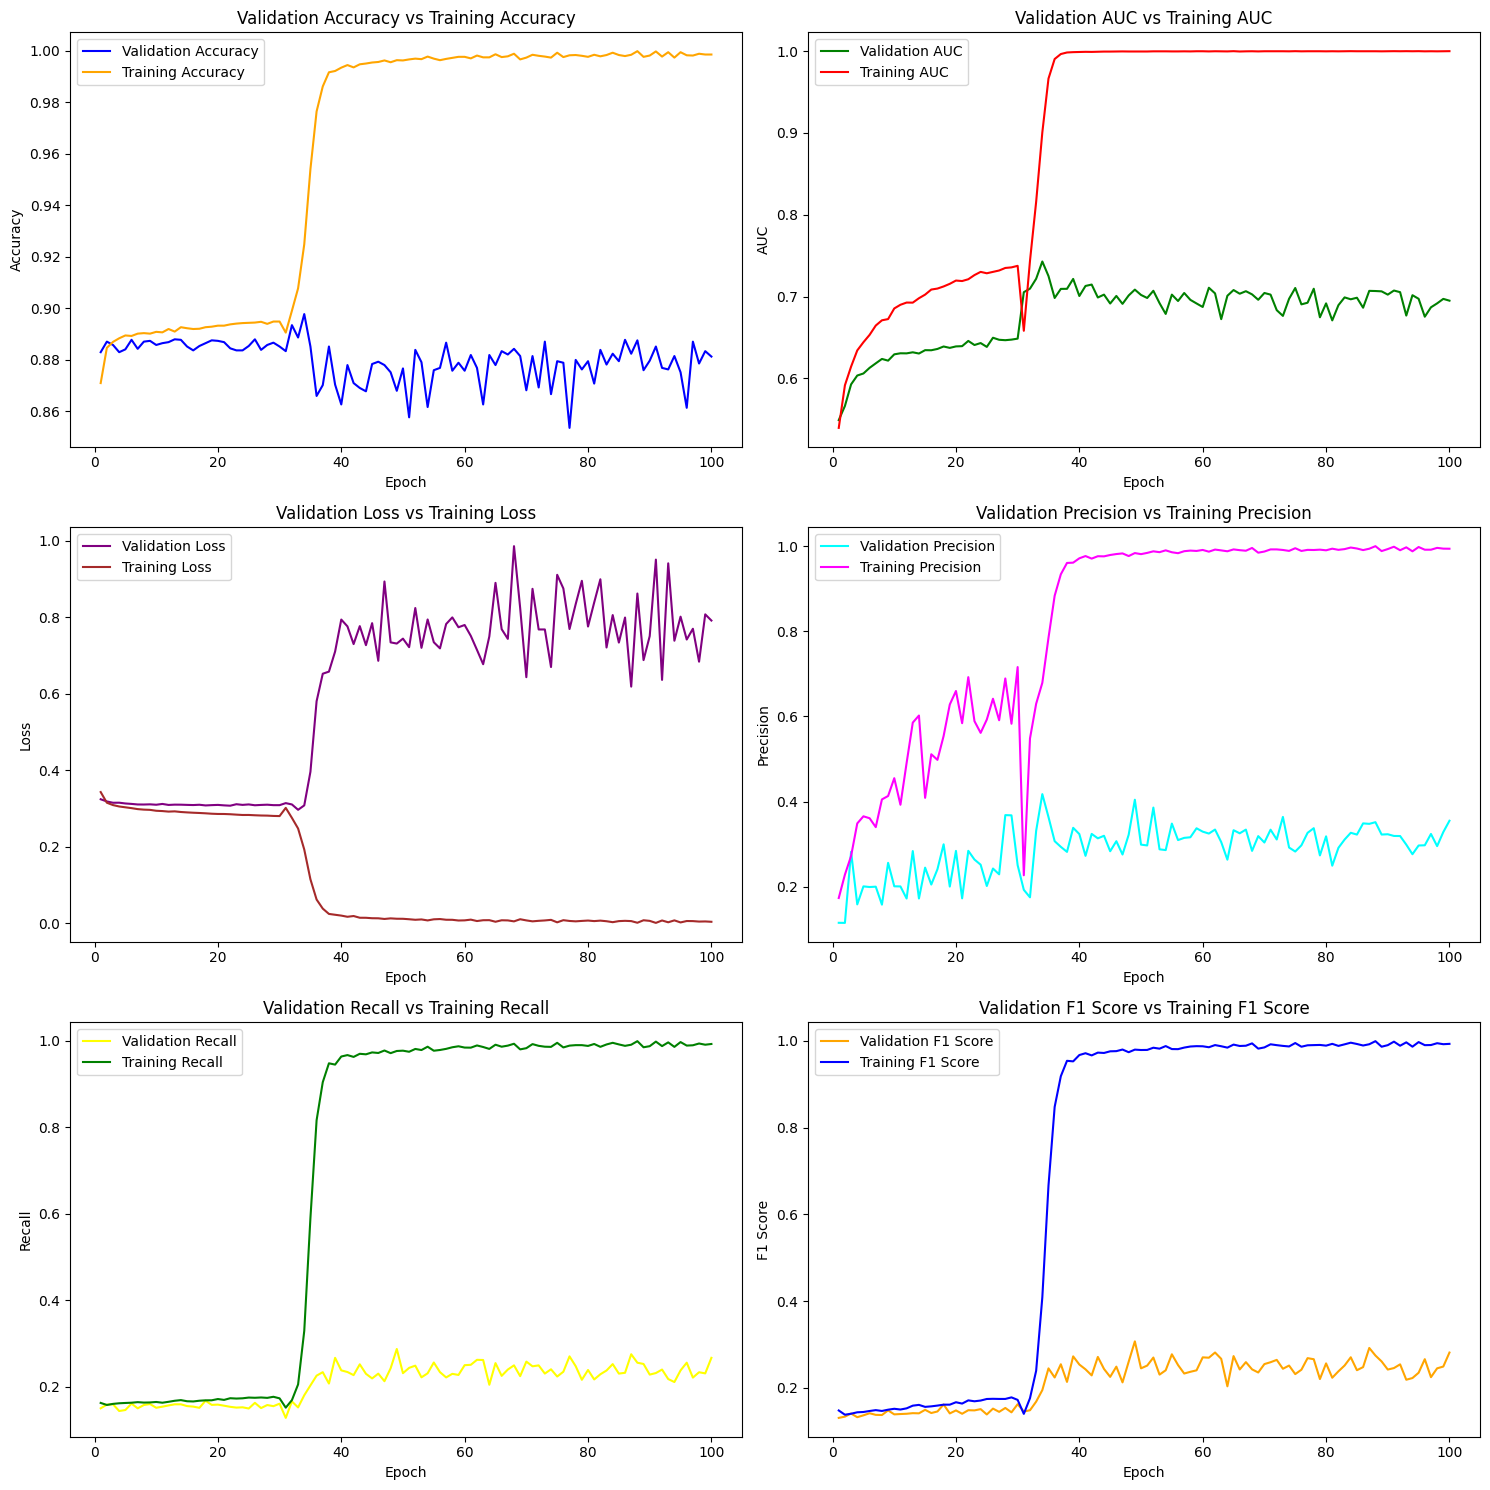

In [28]:
import pandas as pd
import matplotlib.pyplot as plt


# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Plot accuracy
axes[0, 0].plot(history['epoch_number'], history['val_accuracy'], label='Validation Accuracy', color='blue')
axes[0, 0].plot(history['epoch_number'], history['train_accuracy'], label='Training Accuracy', color='orange')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].set_title('Validation Accuracy vs Training Accuracy')
axes[0, 0].legend()

# Plot AUC
axes[0, 1].plot(history['epoch_number'], history['val_auc'], label='Validation AUC', color='green')
axes[0, 1].plot(history['epoch_number'], history['train_auc'], label='Training AUC', color='red')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('AUC')
axes[0, 1].set_title('Validation AUC vs Training AUC')
axes[0, 1].legend()

# Plot loss
axes[1, 0].plot(history['epoch_number'], history['val_loss'], label='Validation Loss', color='purple')
axes[1, 0].plot(history['epoch_number'], history['train_loss'], label='Training Loss', color='brown')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Validation Loss vs Training Loss')
axes[1, 0].legend()

# Plot precision
axes[1, 1].plot(history['epoch_number'], history['val_precision'], label='Validation Precision', color='cyan')
axes[1, 1].plot(history['epoch_number'], history['train_precision'], label='Training Precision', color='magenta')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Precision')
axes[1, 1].set_title('Validation Precision vs Training Precision')
axes[1, 1].legend()

# Plot recall
axes[2, 0].plot(history['epoch_number'], history['val_recall'], label='Validation Recall', color='yellow')
axes[2, 0].plot(history['epoch_number'], history['train_recall'], label='Training Recall', color='green')
axes[2, 0].set_xlabel('Epoch')
axes[2, 0].set_ylabel('Recall')
axes[2, 0].set_title('Validation Recall vs Training Recall')
axes[2, 0].legend()

# Plot F1 score
axes[2, 1].plot(history['epoch_number'], history['val_f1'], label='Validation F1 Score', color='orange')
axes[2, 1].plot(history['epoch_number'], history['train_f1'], label='Training F1 Score', color='blue')
axes[2, 1].set_xlabel('Epoch')
axes[2, 1].set_ylabel('F1 Score')
axes[2, 1].set_title('Validation F1 Score vs Training F1 Score')
axes[2, 1].legend()

# Adjust layout
plt.tight_layout()

# Show the plot
plt.show()

In [29]:
model_path = '/kaggle/working/best_model_precision.pth'
# model_path = '/kaggle/input/20-03-2024-vinbigdata-multilabel-weights/best_model_auc.pth'
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

In [30]:
test_scores_all = []
test_labels_all = []
test_predictions_all = []

correct_test = 0
total_test = 0


# Don't need to keep track of gradients
with torch.no_grad():
    # Set to evaluation mode
    model.eval()

    start = timer()
    #Test loop
    for batch_data in tqdm(test_loader):
        inputs, labels = batch_data[0].to(device), batch_data[1].float().to(device)  

        outputs = model(inputs)
        outputs = outputs.float()
        labels = labels.float()


        scores = torch.sigmoid(outputs)
        predictions = torch.sigmoid(outputs) > 0.5
        total_test += labels.size(0) * labels.size(1)

        correct_test += (predictions == labels).sum().item()

        test_scores_all.extend(scores.detach().cpu().numpy())
        test_labels_all.extend(labels.cpu().numpy())
        test_predictions_all.extend(predictions.cpu().numpy())

    accuracy_test = correct_test / total_test

    print(f"Accuracy: {accuracy_test:.4f}")
    print("correct:", correct_test, " out of ", total_test)

    test_predictions_all = np.array(test_predictions_all).astype(float)
    test_labels_all = np.array(test_labels_all).astype(float)

    print(classification_report(test_labels_all, test_predictions_all, target_names=diseases)) 
    # adjust the target_names

    cm = multilabel_confusion_matrix(test_predictions_all, test_labels_all)
    # we will use macro-averaging strategy.
    accuracy_arr = []
    precision_arr = []
    recall_arr = []
    f1_arr = []

    for i in range(num_classes):
        print(cm[i])
        print(cm[i].sum())

#         cfm_plot = sn.heatmap(cm[i], annot=False)
         # TP + TN / TP + TN  + FP + FN
        accuracy = (cm[i][0][0]+ cm[i][1][1])/cm[i].sum()

        # TP / TP + FP
        precision = cm[i][1][1]/(cm[i][1][0]+cm[i][1][1])

        # TP / TP + FN
        recall = cm[i][1][1]/(cm[i][0][1]+cm[i][1][1]) # sensitivity
        f1 = (2*precision*recall)/(precision+recall)
        print(disease_labels[i],": ",round(accuracy*100,2),"%") ### disease or disease_labels
        print("Precision: ",round(precision,2))
        print("Recall:", round(recall,2))
        print("F1-Score:", round(f1,2))
        print('==========================================================')


        accuracy_arr.append(accuracy)
        precision_arr.append(precision)
        recall_arr.append(recall)
        f1_arr.append(f1)
    
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
            
    accuracy_arr = np.nan_to_num(accuracy_arr, nan=0)
    precision_arr = np.nan_to_num(precision_arr, nan=0)
    recall_arr = np.nan_to_num(recall_arr, nan=0)
    f1_arr = np.nan_to_num(f1_arr, nan=0)
    
    accuracy_macro_test = round(sum(accuracy_arr) / len(accuracy_arr), 4)
    precision_macro_test = round(sum(precision_arr) / len(precision_arr), 4)
    recall_macro_test = round(sum(recall_arr) / len(recall_arr), 4)
    f1_macro_test = round(sum(f1_arr) / len(f1_arr), 4)
    roc_auc_macro_test = round(roc_auc_score(test_labels_all, test_scores_all, average='macro'), 4)

    print("MACRO-averged metrics", end=':- ')
    print(f"accuracy: {accuracy_macro_test}, precision: {precision_macro_test}", end=', ')
    print(f"recall: {recall_macro_test}, f1: {f1_macro_test}, ROC_AUC: {roc_auc_macro_test}")

    infer_time = timer()-start
    print(f"INFERENCE TIME: {(infer_time):.4f} seconds")
    print("-"*120)

100%|██████████| 174/174 [00:23<00:00,  7.30it/s]

Accuracy: 0.8923
correct: 7420  out of  8316
                  precision    recall  f1-score   support

      No finding       0.75      0.87      0.81       907
      Bronchitis       0.53      0.05      0.09       174
Brocho-pneumonia       0.50      0.08      0.14        84
   Other disease       0.33      0.01      0.03        77
   Bronchiolitis       0.00      0.00      0.00        90
       Pneumonia       0.43      0.07      0.12        89

       micro avg       0.74      0.57      0.64      1421
       macro avg       0.42      0.18      0.20      1421
    weighted avg       0.62      0.57      0.54      1421
     samples avg       0.58      0.58      0.58      1421

[[219 118]
 [260 789]]
1386
No finding :  72.73 %
Precision:  0.75
Recall: 0.87
F1-Score: 0.81
[[1204  165]
 [   8    9]]
1386
Bronchitis :  87.52 %
Precision:  0.53
Recall: 0.05
F1-Score: 0.09
[[1295   77]
 [   7    7]]
1386
Brocho-pneumonia :  93.94 %
Precision:  0.5
Recall: 0.08
F1-Score: 0.14
[[1307   76]
 [ 


/tmp/ipykernel_26/3317778632.py:65: RuntimeWarning: invalid value encountered in scalar divide
  f1 = (2*precision*recall)/(precision+recall)
